In [1]:
%matplotlib qt

# Confirmation Bias Project
## Behavioural analyses
#### Experiment 1

We recommend to run this script in Jupyter Notebook. It is possible to not visualize some plots in JupyterLab

##### Import important functions and libraries

In [1]:
import os, glob
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import scipy.stats as stats
from scipy import signal
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
from plotly.subplots import make_subplots
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from matplotlib.lines import Line2D
import statsmodels as sms
pd.options.display.max_columns = None # display all the columns in pandas dataframe
import plotly.graph_objects as go
import plotly.express as px

##### Important functions

In [2]:
def RT_filter(x, sd): 
    # this function was used to filter those trials with a RT that are above X standard deviation from the mean
    rt_mean = x['RT'].mean()
    up_lim = rt_mean + sd * x['RT'].std()
    x = x.loc[(x['RT'] < up_lim) & (x['RT'] > 0), : ]
    return x #the same dataframe with RT filtered

def log_reg_fit(x, f): # this function was used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    PSE = - reg.params.Intercept/reg.params[1]
    # concatenating parameters
    out = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    return out #intercept + weight

def z_RT(x):
    # this function was used to calculate the z score of the RT values from a dataframe 
    rt_mean = x['RT'].mean()
    rt_sd   = x['RT'].std()
    x['RTz'] = (x['RT']- rt_mean)/rt_sd
    x['1/RTz']= 1/x['RT']
    rt_mean1  = x['1/RTz'].mean()
    rt_sd1    = x['1/RTz'].std()
    x['1/RTz']=(x['1/RTz']- rt_mean1)/rt_sd1
    return x

def z_DV(x):
    # this function was used to calculate the z score of the DV values from a dataframe 
    dv_mean = x['DV'].mean()
    dv_sd   = x['DV'].std()
    x['DVz'] = (x['DV']- dv_mean)/dv_sd
    return x

def cartesian(arrays, out=None):
    """
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size) 
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

### Data & variables

In [148]:
# CAUTION !! 
# Change the current path to the folder where you stored the experimental results 

# results_path = 'C:/Users/Angel/Dropbox/ConfBiasProject/Analyses/results' #windows/main
results_path = '/Users/alex/OneDrive - Universitat de Barcelona/Projects/Condcision/Behav_data/FirstExperiment' #windows/main

os.chdir(results_path) # change the current working directory to the results path 

all_df = pd.DataFrame([]) # concatenate all behav subject data together
ddata = pd.DataFrame([]) # concatenate here behav data + dv + orientations


nsubj = 0 # initialize subjects counter

for file in glob.glob("*.psydat"): 
    subjdata = pd.DataFrame([]) # initialize individual subject data variable container
    pfile =  open(os.path.join(results_path, file),"rb")
    nsubj = nsubj + 1
    dat = pickle.load(pfile)
    for block in dat['main_exp']['Exp_blocks']:
        dvdata = pd.DataFrame(signal.sawtooth(4 * (block['trial_orientations']), 0.5),columns=['d1','d2','d3','d4','d5','d6'])
        ddata = pd.concat([block['data'], dvdata, block['trial_orientations']], axis = 1)
        subjdata = pd.concat([subjdata, ddata], axis = 0)
    
    subjdata.insert(0, 'npar', nsubj)
    
    all_df = pd.concat([all_df, subjdata], axis = 0) #concatenate each new subject

all_df.head(10)


npar subj  nblock  ntrial  nrep  cond    DV resp  r_map  correct     RT  \
0     1  p14       0       0     0    -1 -0.38    m     45        1  2.511   
1     1  p14       0       0     1    -1 -0.38    z      0        1  2.051   
2     1  p14       0       0     2    -1 -0.38    m      0       -1  2.242   
3     1  p14       0       1     0    -1 -0.28    m     45        1  2.213   
4     1  p14       0       1     1    -1 -0.28    z      0        1  1.528   
5     1  p14       0       1     2    -1 -0.28    m     45        1  1.269   
6     1  p14       0       2     0     1  0.18    z     45        1  1.332   
7     1  p14       0       2     1     1  0.18    z     45        1  1.426   
8     1  p14       0       2     2     1  0.18    z     45        1  1.664   
9     1  p14       0       3     0    -1 -0.08    m      0       -1  4.060   

         d1        d2        d3        d4        d5        d6     o1     o2  \
0 -0.581859 -0.985758  0.611403 -0.523808 -0.383752 -0.337915  1.735  3.136   
1 -0.581859 -0.985758  0.611403 -0.523808 -0.383752 -0.337915  1.735  3.136   
2 -0.581859 -0.985758  0.611403 -0.523808 -0.383752 -0.337915  1.735  3.136   
3  0.319595  0.563020 -0.220777 -0.691357 -0.825330 -0.858434  2.089  0.957   
4  0.319595  0.563020 -0.220777 -0.691357 -0.825330 -0.858434  2.089  0.957   
5  0.319595  0.563020 -0.220777 -0.691357 -0.825330 -0.858434  2.089  0.957   
6  0.507516 -0.006873 -0.019606  0.209578  0.245747  0.168834  0.592  0.390   
7  0.507516 -0.006873 -0.019606  0.209578  0.245747  0.168834  0.592  0.390   
8  0.507516 -0.006873 -0.019606  0.209578  0.245747  0.168834  0.592  0.390   
9 -0.016540  0.007368  0.316011 -0.947043  0.117904  0.091921  1.957  2.746   

      o3     o4     o5     o6  
0  0.938  0.187  0.242  0.260  
1  0.938  0.187  0.242  0.260  
2  0.938  0.187  0.242  0.260  
3  0.306  1.692  3.073  3.086  
4  0.306  1.692  3.073  3.086  
5  0.306  1.692  3.073  3.086  
6  0.385  0.475  2.060  0.459  
7  0.385  0.475  2.060  0.459  
8  0.385  0.475  2.060  0.459  
9  1.054  1.550  0.439  1.142

### Dataframe experiment 1: coding important variables

In [168]:
df = all_df.copy() # copy tge variable

# relabeling some variables
df['cond'] = all_df['cond'].replace([-1], 0)
df['correct'] = all_df['correct'].replace([-1], 0)

df.insert(5, 'cond-1', 0)    # 0 = previous Diag / 1 = previous Card
df['cond-1'] = df['cond'].shift(1, fill_value  = 0)

# Inserting deci variable
df.insert(9, 'deci', 0)
crit1 = (df['cond']  > 0) & (df['correct'] == 1);    # 0 = diagonal       
crit2 = (df['cond']  < 0) & (df['correct'] == 0);            
crit3 = (df['cond'] == 0) & (df['correct'] == 0);
df.loc[crit1 | crit2 | crit3, 'deci'] = 1 

# Inserting the new necessary columns coding trials properly
df.insert(9, 'deci-1', 0)    # 0 = previous Diag / 1 = previous Card
df.insert(11, 'corr-1', 0) # O = incorrect / 1 = correct
df.insert(7, 'rDV', 0) # rDV (real Decision Variable)
df.insert(10, 'deci-2', 0)    # 0 = 2 previous Diag / 1 = previous Card

# Recoding variables
df['deci-1'] = df['deci'].shift(1, fill_value  = 0) # deci in trial n-1
df['deci-2'] = df['deci-1'].shift(1, fill_value  = 0) # deci in trial n-2
df['corr-1'] = df['correct'].shift(1, fill_value  = 0) # correct in trial n-1


df['rDV'] = np.mean(df.iloc[:,16:22], axis = 1) # average DV
df.head(50)

npar subj  nblock  ntrial  nrep  cond-1  cond       rDV    DV resp  \
0      1  p14       0       0     0       0     0  0.107871 -0.38    m   
1      1  p14       0       0     1       0     0  0.031204 -0.38    z   
2      1  p14       0       0     2       0     0  0.063037 -0.38    m   
3      1  p14       0       1     0       0     0  0.226358 -0.28    m   
4      1  p14       0       1     1       0     0  0.112192 -0.28    z   
5      1  p14       0       1     2       0     0  0.069025 -0.28    m   
6      1  p14       0       2     0       0     1  0.378060  0.18    z   
7      1  p14       0       2     1       1     1  0.393727  0.18    z   
8      1  p14       0       2     2       1     1  0.433394  0.18    z   
9      1  p14       0       3     0       1     0  0.589617 -0.08    m   
10     1  p14       0       3     1       0     0  0.082950 -0.08    z   
11     1  p14       0       3     2       0     0  0.098950 -0.08    m   
12     1  p14       0       4     0       0     0  0.022344 -0.18    m   
13     1  p14       0       4     1       0     0 -0.040489 -0.18    m   
14     1  p14       0       4     2       0     0 -0.137989 -0.18    m   
15     1  p14       0       5     0       0     1  0.314905  0.18    z   
16     1  p14       0       5     1       1     1  0.228072  0.18    m   
17     1  p14       0       5     2       1     1  0.159738  0.18    z   
18     1  p14       0       6     0       1     0  0.170804 -0.08    m   
19     1  p14       0       6     1       0     0  0.299138 -0.08    z   
20     1  p14       0       6     2       0     0  0.144138 -0.08    m   
21     1  p14       0       7     0       0     0  0.396716 -0.18    m   
22     1  p14       0       7     1       0     0  0.072882 -0.18    m   
23     1  p14       0       7     2       0     0  0.095049 -0.18    m   
24     1  p14       0       8     0       0     1  0.360251  0.18    z   
25     1  p14       0       8     1       1     1  0.334751  0.18    m   
26     1  p14       0       8     2       1     1  0.529918  0.18    z   
27     1  p14       0       9     0       1     0  0.563321 -0.08    m   
28     1  p14       0       9     1       0     0  0.387488 -0.08    z   
29     1  p14       0       9     2       0     0  0.237654 -0.08    m   
30     1  p14       0      10     0       0     1  0.827799  0.18    m   
31     1  p14       0      10     1       1     1  0.692299  0.18    z   
32     1  p14       0      10     2       1     1  0.452799  0.18    m   
33     1  p14       0      11     0       1     1  0.598128  0.28    z   
34     1  p14       0      11     1       1     1  0.465794  0.28    m   
35     1  p14       0      11     2       1     1  0.472294  0.28    m   
36     1  p14       0      12     0       1     1  0.305548  0.28    z   
37     1  p14       0      12     1       1     1  0.280048  0.28    m   
38     1  p14       0      12     2       1     1  0.280882  0.28    m   
39     1  p14       0      13     0       1     1  0.326315  0.18    z   
40     1  p14       0      13     1       1     1  0.339315  0.18    m   
41     1  p14       0      13     2       1     1  0.341982  0.18    z   
42     1  p14       0      14     0       1     1  0.568377  0.18    m   
43     1  p14       0      14     1       1     1  0.461543  0.18    z   
44     1  p14       0      14     2       1     1  0.332543  0.18    m   
45     1  p14       0      15     0       1     0 -0.058173 -0.28    z   
46     1  p14       0      15     1       0     0 -0.059840 -0.28    m   
47     1  p14       0      15     2       0     0 -0.075340 -0.28    m   
48     1  p14       0      16     0       0     1  0.396951  0.28    z   
49     1  p14       0      16     1       1     1  0.373285  0.28    m   

    deci-2  deci-1  deci  corr-1  r_map  correct     RT        d1        d2  \
0        0       0     0       0     45        1  2.511 -0.581859 -0.985758   
1        0       0     0       1      0        1  2.051 -0.581859 -0.98

### Reaction Times 
##### Filter those responses with RTs larger than 4 sd

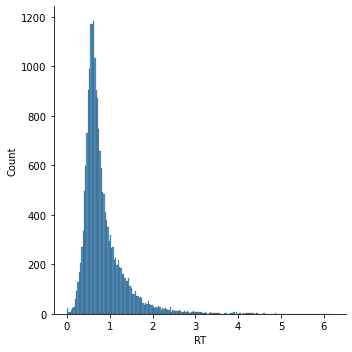

In [6]:
# RTs after apply filter
df = df.groupby(['npar'], group_keys = False).apply(RT_filter, sd = 4)
sns.displot(df.RT)

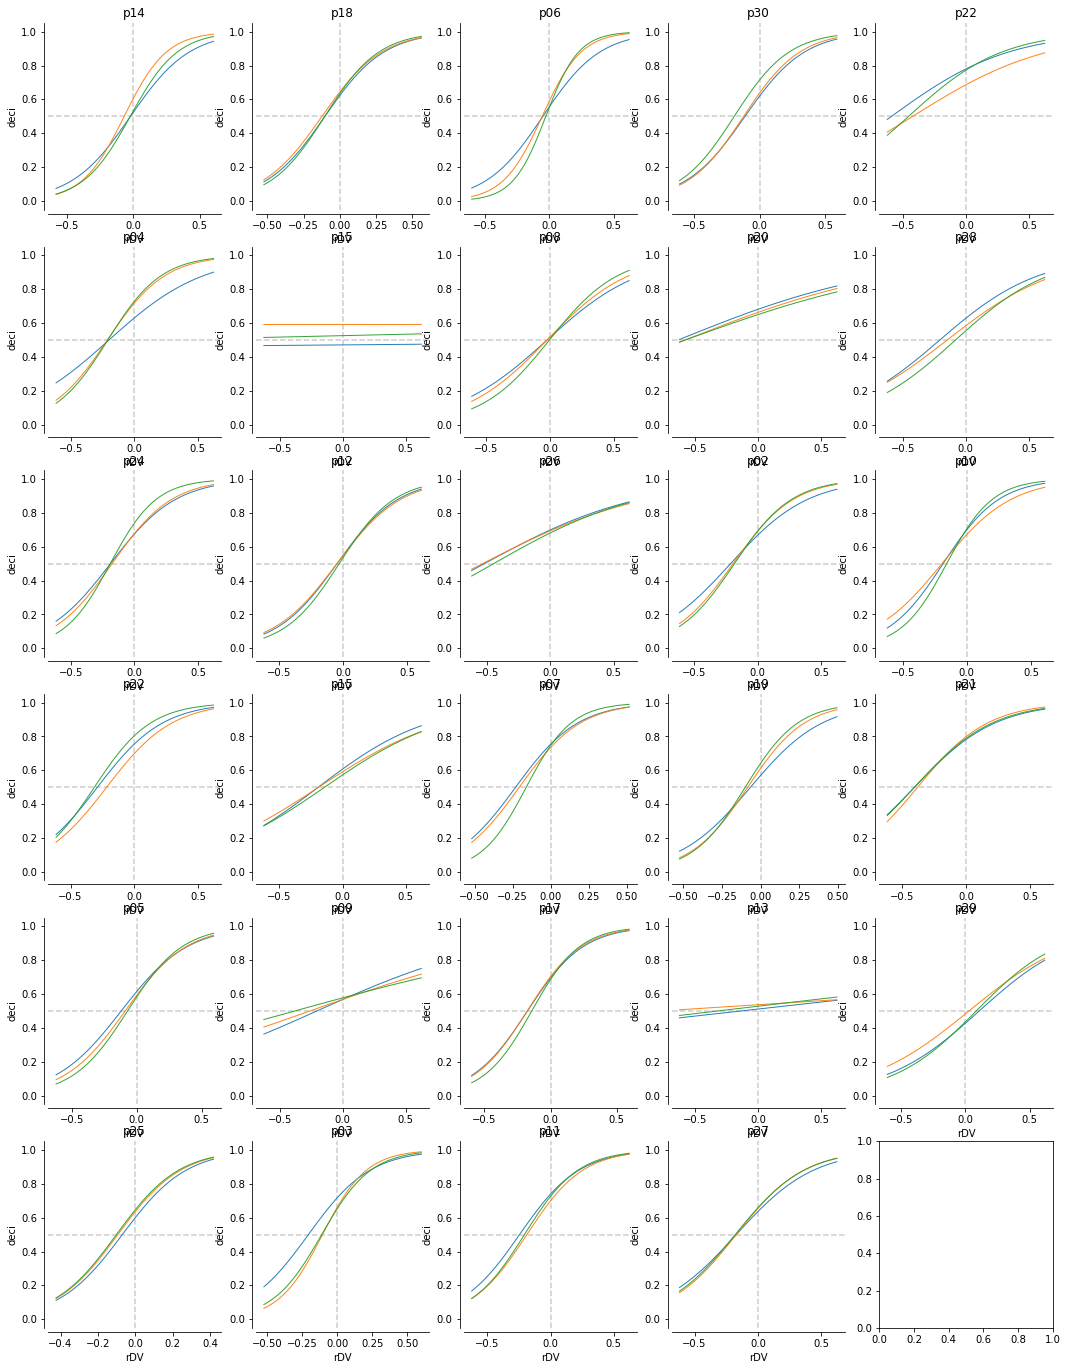

In [150]:
nprows = 6 
npcols = 5

nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar


fig, axes = plt.subplots(nprows, npcols, figsize=(18, 24))
#fig.tight_layout() # improving the space
p = cartesian((np.arange(0,nprows), np.arange(0,npcols)))

for i in npar_labels: #for loop to compute the average by each participant
    df2 = df.loc[df.npar == i,:]
    axes[p[i-1,0],p[i-1,1]].axvline(0, ls='--', color= 'black', alpha=0.2)
    axes[p[i-1,0],p[i-1,1]].axhline(0.5, ls='--', color= 'black', alpha=0.2)
    axes[p[i-1,0],p[i-1,1]].title.set_text(df2.iloc[0,1])
    sns.despine(ax=axes[p[i-1,0],p[i-1,1]],offset=4); # , trim=True
    for cell in nrep_labels:
            #sns.set_palette(mycol)
            sns.regplot(ax=axes[p[i-1,0],p[i-1,1]],x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                             line_kws ={'alpha':0.95, 'lw':1}); #mean all subject
    

#plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
#axes[1].plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); 
#axes[1].plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)

### Removing bad participants

In [156]:
formula = "deci ~ rDV"
log_par = df.groupby(['subj']).apply(log_reg_fit, formula)
log_par.reset_index(inplace = True)
log_par.head(39)
# here it seems that visual inspection shows that p13 and p15 were pretty bad

subj  level_1  intercept    weight       PSE
0   p02        0   0.763633  3.912656 -0.195170
1   p03        0   0.745806  5.443364 -0.137012
2   p04        0   0.763803  3.772047 -0.202490
3   p05        0   0.393212  4.283098 -0.091806
4   p06        0   0.260695  6.055858 -0.043048
5   p07        0   1.069151  5.446206 -0.196311
6   p08        0   0.049048  3.141490 -0.015613
7   p09        0   0.285885  1.068185 -0.267636
8   p10        0   0.805566  4.537422 -0.177538
9   p11        0   0.952507  4.479160 -0.212653
10  p12        0   0.174305  4.253346 -0.040981
11  p13        0   0.101753  0.291524 -0.349036
12  p14        0   0.208811  5.369221 -0.038890
13  p15        0   0.257171  0.681386 -0.377423
14  p17        0   0.823543  5.019859 -0.164057
15  p18        0   0.553333  5.005532 -0.110544
16  p19        0   0.427065  5.128140 -0.083279
17  p20        0   0.686178  1.147146 -0.598161
18  p21        0   1.321325  3.342057 -0.395363
19  p22        0   1.060608  2.873646 -0.369081
20  p24        0   0.822329  4.472721 -0.183854
21  p25        0   0.524167  5.920906 -0.088528
22  p26        0   0.808244  1.609093 -0.502298
23  p27        0   0.617774  3.554627 -0.173794
24  p28        0   0.360534  2.502674 -0.144059
25  p29        0  -0.203161  2.740624  0.074130
26  p30        0   0.647231  4.543593 -0.142449

In [157]:
df = df.loc[df.subj != 'p13',:] #removed because sd lower than 2 sd from mean
df = df.loc[df.subj != 'p15',:]     #removed because not followed the instructions: counted
df.reset_index(drop=True, inplace=True) # reset the row indexes of the pandas dataframe

##### Dataset with good participants

In [136]:
# Final n after removing bad participants:
print("Subjects in the final dataset = " + str(len(np.unique(df.npar))))
print(np.unique(df.npar)) # those are the particiapnts that remain in the data anlyses

Subjects in the final dataset = 29
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


In [158]:
estimations = (np.max(np.unique(df.ntrial)) + 1)* (np.max(np.unique(df.nblock)) + 1)
print("number of trials by participant was " + str(estimations))

number of trials by participant was 240


###### The original dataset was transformed to long format to perform some of the necessary analyses
 - It allows to perform reverse correlation analyses
 - We inserted new variables to this dataset

In [164]:
df.head(2)

npar subj  nblock  ntrial  nrep  cond    DV       rDV resp  r_map  deci-2  \
0     1  p14       0       0     0     0 -0.38 -0.366948    m     45       0   
1     1  p14       0       0     1     0 -0.38 -0.366948    z      0       0   

   deci-1  deci  corr-1  correct     RT        d1        d2        d3  \
0       0     0       0        1  2.511 -0.581859 -0.985758  0.611403   
1       0     0       1        1  2.051 -0.581859 -0.985758  0.611403   

         d4        d5        d6     o1     o2     o3     o4     o5    o6  \
0 -0.523808 -0.383752 -0.337915  1.735  3.136  0.938  0.187  0.242  0.26   
1 -0.523808 -0.383752 -0.337915  1.735  3.136  0.938  0.187  0.242  0.26   

   pre_cond  
0         0  
1         0

In [1]:
# df to long format
dflong = pd.melt(df, id_vars=['npar','subj','nblock','ntrial','cond-1','cond','nrep', 'deci-2','deci-1','deci', 'corr-1', 'correct','RT'], value_vars=['d1', 'd2', 'd3', 'd4', 'd5', 'd6'])
dflong.shape
dflong.rename(columns={'variable' : "stim", 'value' : 'dv'}, inplace=True)

out = pd.melt(df, id_vars=['npar','subj','nblock','ntrial','cond-1','cond','nrep', 'deci-2','deci-1','deci', 'corr-1', 'correct','RT'], value_vars=['o1', 'o2', 'o3', 'o4', 'o5', 'o6'])
dflong['orient'] = out.value
del out
dflong.insert(7, 'expected', "U") 
# an stimuli is expected when the previous dv and previous deci were the same (i.e.DV==D & pre_deci == D)
dflong.loc[(dflong['deci-1'] == 0) & (dflong.dv < 0) | (dflong['deci-1'] == 1) & (dflong.dv > 0), "expected"]  = "E"

#dflong["cond-1"] = "D" # check that you select the cond of prev stim (not the prev trial). Think what you want
#dflong.loc[(dflong.dv < 0), "cond-1"]  = "C"

dflong.head(30)


NameError: name 'pd' is not defined

In [ ]:

dflong.insert(6, 'expected', "U") 
# an stimuli is expected when the previous dv and previous deci were the same (i.e.DV==D & pre_deci == D)
dflong.loc[(dflong['deci-1'] == 0) & (dflong.dv < 0) | (dflong['deci-1'] == 1) & (dflong.dv > 0), "expected"]  = "E"




dflong["pre_cond"].replace({0: "C", 1: "D"}, inplace=True)
dflong.insert(7, 'cong_stim', 'I')
dflong.loc[(dflong.pre_cond == 'C') & (dflong.cond == 'C') | (dflong.pre_cond == 'D') & (dflong.cond == 'D'), 'cong_stim'] = 'C'

dflong.insert(7, 'cong_deci', 'I')
dflong.loc[(dflong.pre_deci == 0) & (dflong.cond == 'C') | (dflong.pre_deci == 1) & (dflong.cond == 'D'), 'cong_deci'] = 'C'

dflong.insert(8, 'pre_expected', "U")
dflong['pre_expected'] = dflong['expected']
dflong['pre_expected'] = dflong['pre_expected'].shift(1, fill_value = "U")

dflong.insert(9, 'cong_long', 0)
# one participant is congruent when the 2 last pre decis and deci variable were the same 
dflong.loc[(dflong.expected == 'U') & (dflong.pre_expected == 'U') | (dflong.expected == 'E') & (dflong.pre_expected == 'E'), 'cong_long'] = 1
#bins <- divids the orientation of the stimuli in small categories. it groups similar oriented stimuli together
dflong['bins'] = pd.cut(x=dflong['dv'], bins=[-0.99, -0.33, 0.33, 0.99], labels=[-0.60, 0, 0.60])

dflong.insert(17, '1/RT', 0)
dflong['1/RT'] = 1/dflong['RT']

print(dflong.head())

formula = "deci ~ dv"
log_regstim_params = dflong.groupby(['npar','nrep', 'stim']).apply(log_reg_fit, formula)
log_regstim_params.reset_index(inplace = True)

In [173]:
dflong.head(30)

npar subj  nblock  ntrial  cond-1  cond  nrep  deci-2  deci-1  deci  \
0      1  p14       0       0       0     0     0       0       0     0   
1      1  p14       0       0       0     0     1       0       0     0   
2      1  p14       0       0       0     0     2       0       0     1   
3      1  p14       0       1       0     0     0       0       1     0   
4      1  p14       0       1       0     0     1       1       0     0   
5      1  p14       0       1       0     0     2       0       0     0   
6      1  p14       0       2       0     1     0       0       0     1   
7      1  p14       0       2       1     1     1       0       1     1   
8      1  p14       0       2       1     1     2       1       1     1   
9      1  p14       0       3       1     0     0       1       1     1   
10     1  p14       0       3       0     0     1       1       1     0   
11     1  p14       0       3       0     0     2       1       0     0   
12     1  p14       0       4       0     0     0       0       0     0   
13     1  p14       0       4       0     0     1       0       0     0   
14     1  p14       0       4       0     0     2       0       0     0   
15     1  p14       0       5       0     1     0       0       0     1   
16     1  p14       0       5       1     1     1       0       1     1   
17     1  p14       0       5       1     1     2       1       1     1   
18     1  p14       0       6       1     0     0       1       1     1   
19     1  p14       0       6       0     0     1       1       1     1   
20     1  p14       0       6       0     0     2       1       1     1   
21     1  p14       0       7       0     0     0       1       1     0   
22     1  p14       0       7       0     0     1       1       0     0   
23     1  p14       0       7       0     0     2       0       0     0   
24     1  p14       0       8       0     1     0       0       0     1   
25     1  p14       0       8       1     1     1       0       1     1   
26     1  p14       0       8       1     1     2       1       1     1   
27     1  p14       0       9       1     0     0       1       1     1   
28     1  p14       0       9       0     0     1       1       1     1   
29     1  p14       0       9       0     0     2       1       1     1   

    corr-1  correct     RT stim        dv  orient  
0        0        1  2.511   d1 -0.581859   1.735  
1        1        1  2.051   d1 -0.581859   1.735  
2        1        0  2.242   d1 -0.581859   1.735  
3        0        1  2.213   d1  0.319595   2.089  
4        1        1  1.528   d1  0.319595   2.089  
5        1        1  1.269   d1  0.319595   2.089  
6        1        1  1.332   d1  0.507516   0.592  
7        1        1  1.426   d1  0.507516   0.592  
8        1        1  1.664   d1  0.507516   0.592  
9        1        0  4.060   d1 -0.016540   1.957  
10       0        1  1.020   d1 -0.016540   1.957  
11       1        1  1.116   d1 -0.016540   1.957  
12       1        1  1.787   d1 -0.834479   0.065  
13       1        1  1.410   d1 -0.834479   0.065  
14       1        1  0.825   d1 -0.834479   0.065  
15       1        1  1.660   d1  0.296677   2.080  
16       1        1  1.139   d1  0.296677   2.080  
17       1        1  0.729   d1  0.296677   2.080  
18       1        0  1.210   d1 -0.516169   0.190  
19       0        0  1.980   d1 -0.516169   0.190  
20       0        0  1.050   d1 -0.516169   0.190  
21       0        1  2.652   d1  0.734671   2.252  
22       1        1  0.709   d1  0.734671   2.252  
23       1        1  0.842   d1  0.734671   2.252  
24       1        1  0.997   d1  0.590512   2.517  
25       1        1  0.844   d1  0.590512   2.517  
26       1        1  2.015   d1  0.590512   2.517  
27       1        0  2.958   d1 -0.804958   3.065  
28       0        0  1.903   d1 -0.804958   3.065  
29       0        0  1.004   d1 -0.804958   3.065

In [12]:
# new dataframe, it measures the particular effect by each stimuli position.
# it allows to measure the effect of each particular stimuli position in the final choice
# and to estimate if previous stimuli affect the final decision

# df to long format
dflong = pd.melt(df, id_vars=['npar','nblock','ntrial','nrep', 'deci','pre_deci', 'pre_correct', 'correct', 'first_deci', 'pre_cond', 'RT', 'RTz', 'pre_RTz'], value_vars=['d1', 'd2', 'd3', 'd4', 'd5', 'd6'])
dflong.shape
dflong.rename(columns={'variable' : "stim", 'value' : 'dv'}, inplace=True)

out = pd.melt(df, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci', 'pre_correct', 'correct', 'first_deci', 'pre_cond', 'RT', 'RTz', 'pre_RTz'], value_vars=['o1', 'o2', 'o3', 'o4', 'o5', 'o6'])
dflong['orient'] = out.value
del out

dflong.insert(6, 'expected', "U") 
# an stimuli is expected when the previous dv and previous deci were the same (i.e.DV==D & pre_deci == D)
dflong.loc[(dflong.pre_deci == 0) & (dflong.dv < 0) | (dflong.pre_deci == 1) & (dflong.dv > 0), "expected"]  = "E"

dflong.insert(4, 'cond', "D")
dflong.loc[(dflong.dv < 0), "cond"]  = "C"

dflong["pre_cond"].replace({0: "C", 1: "D"}, inplace=True)
dflong.insert(7, 'cong_stim', 'I')
dflong.loc[(dflong.pre_cond == 'C') & (dflong.cond == 'C') | (dflong.pre_cond == 'D') & (dflong.cond == 'D'), 'cong_stim'] = 'C'

dflong.insert(7, 'cong_deci', 'I')
dflong.loc[(dflong.pre_deci == 0) & (dflong.cond == 'C') | (dflong.pre_deci == 1) & (dflong.cond == 'D'), 'cong_deci'] = 'C'

dflong.insert(8, 'pre_expected', "U")
dflong['pre_expected'] = dflong['expected']
dflong['pre_expected'] = dflong['pre_expected'].shift(1, fill_value = "U")

dflong.insert(9, 'cong_long', 0)
# one participant is congruent when the 2 last pre decis and deci variable were the same 
dflong.loc[(dflong.expected == 'U') & (dflong.pre_expected == 'U') | (dflong.expected == 'E') & (dflong.pre_expected == 'E'), 'cong_long'] = 1
#bins <- divids the orientation of the stimuli in small categories. it groups similar oriented stimuli together
dflong['bins'] = pd.cut(x=dflong['dv'], bins=[-0.99, -0.33, 0.33, 0.99], labels=[-0.60, 0, 0.60])

dflong.insert(17, '1/RT', 0)
dflong['1/RT'] = 1/dflong['RT']

print(dflong.head())

formula = "deci ~ dv"
log_regstim_params = dflong.groupby(['npar','nrep', 'stim']).apply(log_reg_fit, formula)
log_regstim_params.reset_index(inplace = True)

   npar  nblock  ntrial  nrep cond  deci  pre_deci cong_deci pre_expected  \
0   1.0       0       0     0    C     0         0         C            U   
1   1.0       0       0     1    C     0         0         C            E   
2   1.0       0       0     2    C     1         0         C            E   
3   1.0       0       1     0    D     0         1         C            E   
4   1.0       0       1     1    D     0         0         I            E   

   cong_long cong_stim expected  pre_correct  correct  first_deci pre_cond  \
0          0         C        E            0        1           0        C   
1          1         C        E            1        1           0        C   
2          1         C        E            1        0           0        C   
3          1         I        E            0        1           0        C   
4          0         I        U            1        1           1        C   

      RT      1/RT       RTz   pre_RTz stim        dv  orient bins  

### Congruency between series of stimuli

##### Dflong for previous orientations and stimuli

In [13]:
# In this chunk, we will compute two important things. We will group stimuli depending on their similar orientation
# compared with the orientation of the previous stimuli and also, we will group stimuli depending on the previous
# category. Two stimuli would be grouped together if they were preceded by a stimuli from the same category (Diag follwd Diag)

# selecting the stimuli DV
stim_dec = df[['d1','d2','d3','d4','d5','d6']]
# Simplify the labels
stim_dec[stim_dec > 0] = 1
stim_dec[stim_dec < 0] = 0

diff_stim_dec = np.diff(stim_dec, axis  = 1)
out = abs(pd.DataFrame(diff_stim_dec, index = df.index, columns = ["cd2","cd3","cd4","cd5","cd6"]))

# resetting indexes in order to be able to concatenate the dataframes 
out.reset_index(drop=True, inplace=True)

# concatenating vertically (over columns)
df.reset_index(drop=True, inplace=True)
out.reset_index(drop=True, inplace=True)
out = pd.concat([df, out], axis = 1)
# transforming data to long format
out = pd.melt(out, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci'], value_vars=['cd2', 'cd3', 'cd4', 'cd5', 'cd6'])
out.head()

# dataset removing first stimulus of the sequence in order to append whether the previous stim is congruent or incongruent
dflong_sd = dflong.loc[dflong.stim != "d1", : ]
dflong_sd.reset_index(drop=True, inplace=True)
out.reset_index(drop=True, inplace=True)
dflong_sd = pd.concat([dflong_sd, out.value], axis = 1)

dflong_sd.rename(columns = {'value' : 'pre_stim'}, inplace = True)

#Appending information about the physical difference between the pre-stimulus and current orientation (classifyin in similar & different physically)

stim_ori = df[['o1','o2','o3','o4','o5','o6']]

diff_stim_ori = abs(np.diff(np.rad2deg(stim_ori), axis  = 1))
diff_stim_ori[diff_stim_ori < 67.5] = 0
diff_stim_ori[diff_stim_ori > 67.5] = 1
diff_stim_ori
out = abs(pd.DataFrame(diff_stim_ori, columns = ["co2","co3","co4","co5","co6"]))

# concatenating vertically (over columns)
out = pd.concat([df, out], axis = 1)
# transforming data to long format
out = pd.melt(out, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci'], value_vars=["co2","co3","co4","co5","co6"])
out.rename(columns = {'value' : 'pre_orient'}, inplace = True) # if the difference is smaller than 67.5 degrees the stimuli are assumed to be similar

dflong_sd = pd.concat([dflong_sd, out.pre_orient], axis = 1)
dflong_sd.head()

/var/folders/3_/f5fh042n51bbps6b2y9l2mkr0000gn/T/ipykernel_20861/2078975710.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stim_dec[stim_dec > 0] = 1
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3713: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/var/folders/3_/f5fh042n51bbps6b2y9l2mkr0000gn/T/ipykernel_20861/2078975710.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

npar  nblock  ntrial  nrep cond  deci  pre_deci cong_deci pre_expected  \
0   1.0       0       0     0    C     0         0         C            E   
1   1.0       0       0     1    C     0         0         C            E   
2   1.0       0       0     2    C     1         0         C            E   
3   1.0       0       1     0    D     0         1         C            E   
4   1.0       0       1     1    D     0         0         I            E   

   cong_long cong_stim expected  pre_correct  correct  first_deci pre_cond  \
0          1         C        E            0        1           0        C   
1          1         C        E            1        1           0        C   
2          1         C        E            1        0           0        C   
3          1         I        E            0        1           0        C   
4          0         I        U            1        1           1        C   

      RT      1/RT       RTz   pre_RTz stim        dv  orient bins  pre_stim  \
0  2.511  0.398248  2.501639  0.000000   d2 -0.985758   3.136 -0.6       0.0   
1  2.051  0.487567  1.700225  2.501639   d2 -0.985758   3.136 -0.6       0.0   
2  2.242  0.446030  2.032986  1.700225   d2 -0.985758   3.136 -0.6       0.0   
3  2.213  0.451875  1.982462  2.032986   d2  0.563020   0.957  0.6       0.0   
4  1.528  0.654450  0.789052  1.982462   d2  0.563020   0.957  0.6       0.0   

   pre_orient  
0         1.0  
1         1.0  
2         1.0  
3         0.0  
4         0.0

## Plots experiment 1

<font size="5"> _Figure 2A. Logistic regression fit for each presentation._

Repeating the same sequence of stimuli makes the participants' estimation more similar to the real average of the sequence?

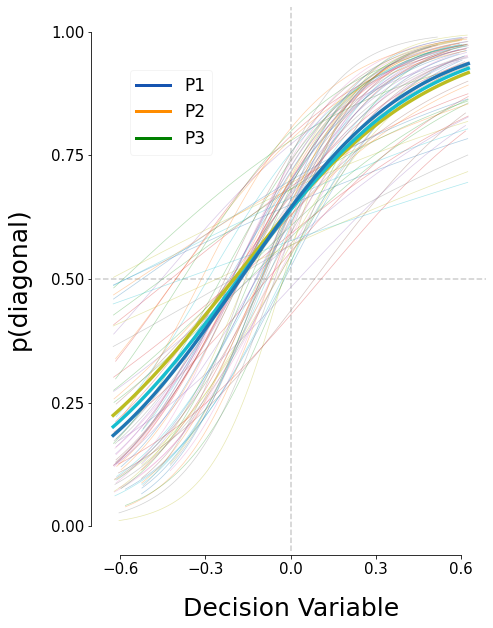

In [14]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

#mycol = ["#1654B0", "darkorange", "g"]
sns.set_palette(mycol)
ax = plt.axvline(0, ls='--', color= 'black', alpha=0.2)
ax = plt.axhline(0.5, ls='--', color= 'black', alpha=0.2)
for i in npar_labels: #for loop to compute the average by each participant
    df2=df.loc[df.npar == i,:]
    for cell in nrep_labels:
        sns.set_palette(mycol)
        ax = sns.regplot(x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                         line_kws ={'alpha':0.35, 'lw':0.7}); #mean all subject

for cell in nrep_labels: #for loop to compute the plot by the average sample
    #sns.set_palette(mycol)
    ax = sns.regplot(x="rDV", y="deci",  data=df.loc[df.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                     line_kws ={'lw':3.4});
    
sns.despine(offset=4, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); 
plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)
#plt.savefig('deci_x_nrep.png',bbox_inches='tight')

<font size="3"> _Check whether differences are statistically significant._

Logisitc regression model with number of presentation

In [15]:
# make the model to estimate if there are statistical differences in weight or the intercept
formula = "deci ~ rDV"
log_reg_nrep = df.groupby(['npar', 'nrep']).apply(log_reg_fit, formula)
log_reg_nrep.reset_index(inplace = True)
log_reg_nrep.tail(5)

npar  nrep  level_2  intercept    weight       PSE
73  28.0     1        0   0.844057  4.507368 -0.187262
74  28.0     2        0   0.973941  4.711977 -0.206695
75  29.0     0        0   0.559552  3.270782 -0.171076
76  29.0     1        0   0.640704  3.748575 -0.170919
77  29.0     2        0   0.658416  3.667405 -0.179532

<font size="4"> _Statistical tests for Weight._

In [16]:
# Means in weight for presentation

dat = log_reg_nrep.loc[log_reg_nrep.nrep == 0,:] # without pre_deci as a factor
print('Weight mean at P1: ')
print(np.mean(dat.weight))
dat = log_reg_nrep.loc[log_reg_nrep.nrep == 1,:] # without pre_deci as a factor
print('Weight mean at P2: ')
print(np.mean(dat.weight))
dat = log_reg_nrep.loc[log_reg_nrep.nrep == 2,:] # without pre_deci as a factor
print('Weight mean at P31: ')
print(np.mean(dat.weight))

Weight mean at P1: 
3.5897115912341824
Weight mean at P2: 
3.947716039169928
Weight mean at P31: 
4.347734118764338


In [17]:
#Checking statistical differences in Weight between the number of repetitions
pg.rm_anova(dv = 'weight', within = ['nrep'], subject = 'npar', data=log_reg_nrep, detailed = True, correction = True)

Source         SS  DF        MS          F     p-unc  p-GG-corr       np2  \
0   nrep   7.477425   2  3.738712  13.439864  0.000021    0.00004  0.349634   
1  Error  13.909041  50  0.278181        NaN       NaN        NaN       NaN   

        eps sphericity   W-spher   p-spher  
0  0.920432       True  0.913553  0.337914  
1       NaN        NaN       NaN       NaN

In [19]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within='nrep', subject='npar', padjust='bonf', 
                   tail='two-sided', effsize = 'cohen', data=log_reg_nrep) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -1.671619  26.0  two-sided  0.106594   
1     nrep  0  2    True        True -4.630703  26.0  two-sided  0.000089   
2     nrep  1  2    True        True -3.775923  26.0  two-sided  0.000836   

     p-corr p-adjust     BF10     cohen  
0  0.319782     bonf    0.694 -0.182036  
1  0.000267     bonf  294.011 -0.465816  
2  0.002509     bonf   39.864 -0.272053

In [20]:
#Checking statistical differences in Intercept between the number of repetitions
pg.rm_anova(dv = 'intercept', within = ['nrep'], subject = 'npar', data=log_reg_nrep, 
            detailed = True, correction = True)

Source        SS  DF        MS         F     p-unc  p-GG-corr       np2  \
0   nrep  0.015701   2  0.007850  0.449761  0.640238   0.639228  0.017004   
1  Error  0.907647  52  0.017455       NaN       NaN        NaN       NaN   

        eps sphericity   W-spher   p-spher  
0  0.994771       True  0.994744  0.936246  
1       NaN        NaN       NaN       NaN

<font size="2"> _t-test showed significant differences in weight in the third presentation compared with previous presentations._

<font size="4"> _Statistical tests for PSE._

In [21]:
#Checking statistical differences in Intercept between the number of repetitions
pg.rm_anova(dv = 'PSE', within = ['nrep'], subject = 'npar', 
            data=log_reg_nrep, detailed = True, correction = True)

Source        SS  DF        MS         F     p-unc  p-GG-corr       np2  \
0   nrep  0.009026   2  0.004513  4.299747  0.018702   0.021581  0.141907   
1  Error  0.054580  52  0.001050       NaN       NaN        NaN       NaN   

        eps sphericity      W-spher  p-spher  
0  0.924295       True  2962.962187      1.0  
1       NaN        NaN          NaN      NaN

In [22]:
pg.pairwise_ttests(dv='PSE', within='nrep', subject='npar', padjust='bonf', 
                   tail='two-sided', effsize = 'cohen', data=log_reg_nrep) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -1.785834  26.0  two-sided  0.085796   
1     nrep  0  2    True        True -2.708191  26.0  two-sided  0.011803   
2     nrep  1  2    True        True -1.136442  26.0  two-sided  0.266138   

     p-corr p-adjust   BF10     cohen  
0  0.257388     bonf  0.818 -0.105258  
1  0.035408     bonf  4.056 -0.153605  
2  0.798415     bonf  0.365 -0.056382

<font size="2"> _t-test showed significant differences in PSE between the initial and final presentations._

<font size="5"> _Figure 2B. Beta weight for each presentation._

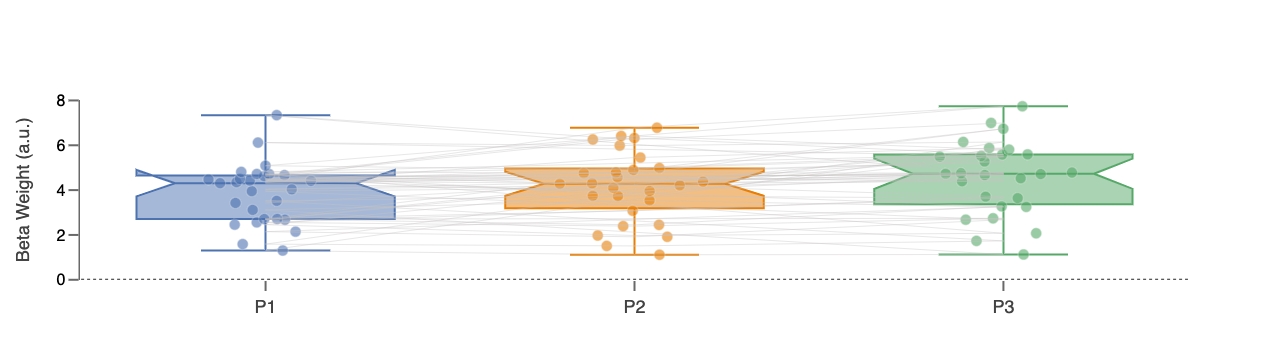

In [23]:
fig = go.Figure()

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_nrep
fig.add_trace(go.Scatter( #lineplot for different category
    y=dat['weight'], x=dat['nrep'], line=dict(color='#C6C2C2', width=0.4)))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==0,:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all',
    marker_color = 'rgba(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)',
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, ))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==1,:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all', marker_color = 'rgba(232, 126, 4, 1)', 
    jitter=0.6, 
    pointpos=0,
        marker=dict(color='#2A88D4',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, ))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==2,:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all',
    marker_color = 'rgba(0.3333333333333333, 0.6588235294117647, 0.40784313725490196, 1)',
    jitter=0.6, 
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, ))

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(tickvals= [0,2,4,6,8], ticktext=['0', '2', '4', '6', '8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_yaxes(showgrid=False)

fig.update_layout(
    yaxis_title="Beta Weight (a.u.)",
    font=dict(
        family="Balto, sans-serif", size=15, color= "#424242"))
fig.update_traces(showlegend=False)

fig['layout']['yaxis'].update(range=[-0.01, 8.02]);
fig.show()

<font size="5"> _Figure 2C. PSE for each presentation._

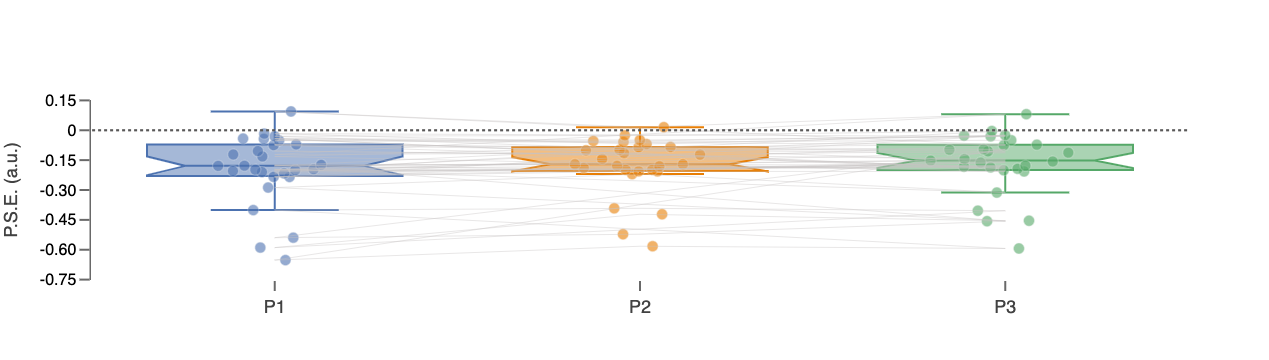

In [24]:
fig = go.Figure()

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_nrep
fig.add_trace(go.Scatter( #lineplot for different category
    y=dat['PSE'], x=dat['nrep'],
    line=dict(color='#C6C2C2', width=0.4)))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==0,:]
fig.add_trace(go.Box(y=dat['PSE'], x=dat['nrep'], boxpoints='all',
    marker_color = 'rgba(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)',
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==1,:]
fig.add_trace(go.Box(y=dat['PSE'], x=dat['nrep'], boxpoints='all',
    marker_color = 'rgba(232, 126, 4, 1)', 
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==2,:]
fig.add_trace(go.Box(y=dat['PSE'], x=dat['nrep'], boxpoints='all',
    marker_color = 'rgba(0.3333333333333333, 0.6588235294117647, 0.40784313725490196, 1)',
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4',size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,))

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, 
                 tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(tickvals= [-0.75,-.60, -.45,-.30,-.15, 0, .15], 
                 ticktext=['-0.75','-0.60', '-0.45','-0.30','-0.15', '0', '0.15'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="P.S.E. (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))
fig.update_traces(showlegend=False)

fig['layout']['yaxis'].update(range=[-0.752, 0.152]);

fig.show()

<font size="5"> _Figure 3A. Logistic regression fits for each presentation separated by cardinal & diagonal._

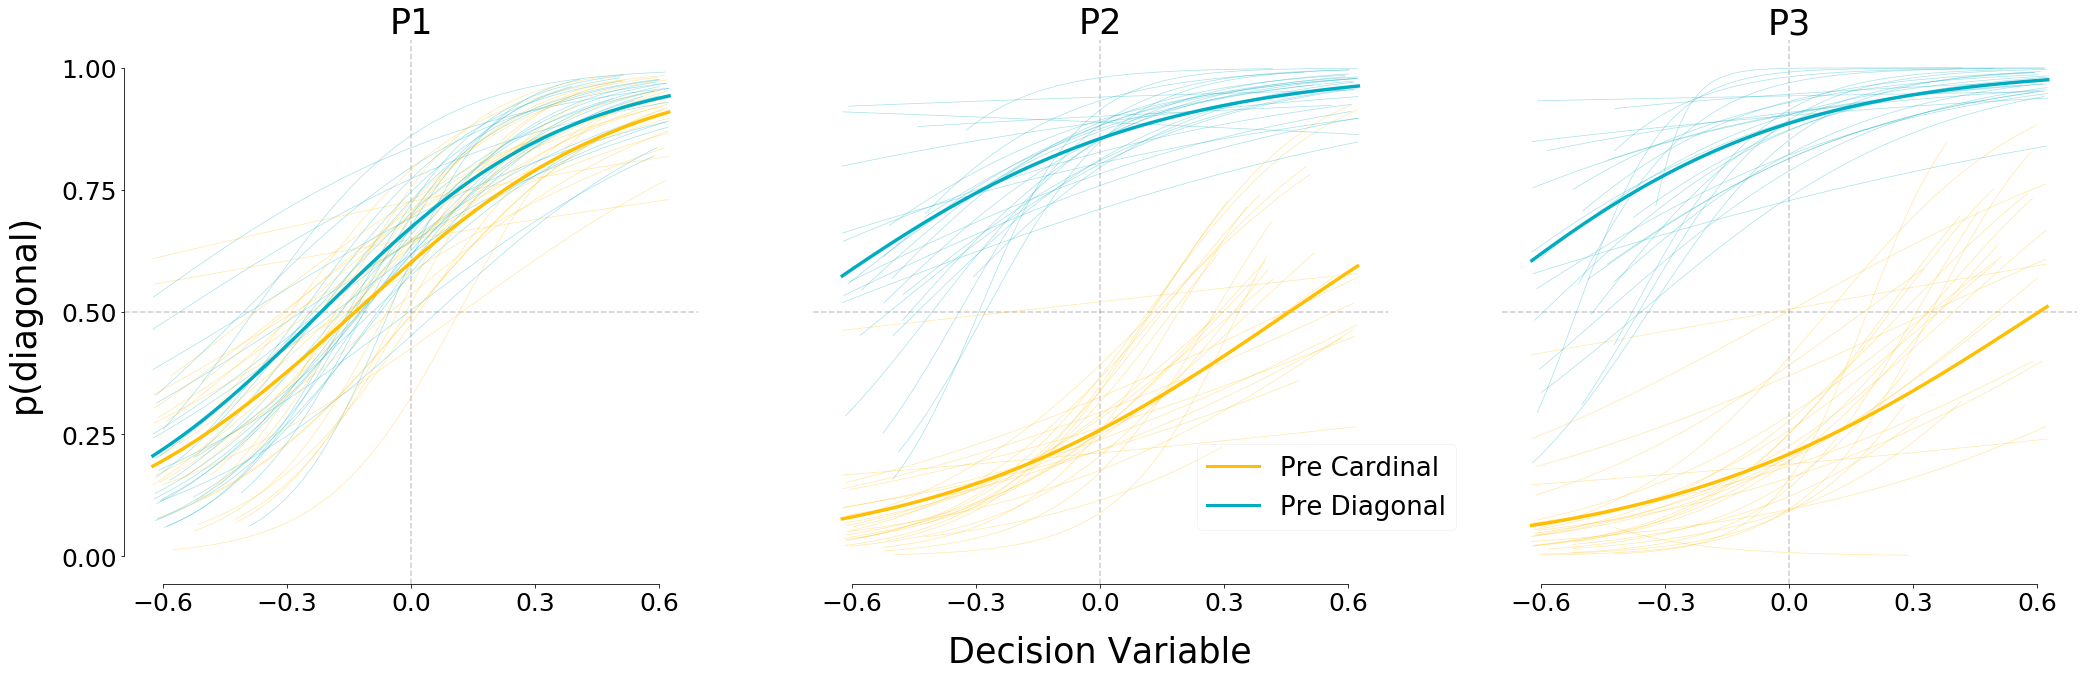

In [25]:
# Previous decisions biases the next response? Previous decision might bias how we estimate the next presentation
# of the trial. Let's find out if previous cardinal decision generates different probabilities to answer diagonal 
# compared with when they previously responded diagonal to equivalent sequences

pre_deci_labels = np.unique(df.pre_deci)     #pre_deci
plt.subplots(ncols=2, figsize=(35, 10))

#mycol = ["#ffbf00", '#70C1B3'] #cardinal #diagonal
mycol = ['#ffbf00' , '#00acc1'] #cardinal #diagonal

sns.set_palette(mycol)
#plt.suptitle("DV for previous decision for the different repetitions", fontsize=20)

plt.subplot(1, 3, 1)
ax0 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax0 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for i in npar_labels: #this for loop makes the plot for each participant for P1
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax0 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 0),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  
                          label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
for cell in pre_deci_labels: #to compute the average for P1
    ax0 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 0),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  
                      label=cell, truncate=True, line_kws={'lw':3.4}); 
sns.despine(ax= ax0, offset=0, trim=True);
plt.ylabel('p(diagonal)', fontsize = 35, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 25); 
plt.title('P1', fontsize= 35); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 25); 
plt.xlabel(' ', fontsize = 0)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Pre Cardinal', 'Pre Diagonal']; 

plt.subplot(1, 3, 2)
ax1 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax1 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for cell in pre_deci_labels: #to compute the average for P2
    ax1 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 1),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, 
                      ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4});   
for i in npar_labels: #this for loop makes the plot for each participant for P2
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax1 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 1),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                          line_kws ={'alpha':0.35, 'lw':0.7});
sns.despine(ax= ax1, offset=0, trim=True);
sns.despine(ax=ax1, left=True)
plt.xlabel('Decision Variable', fontdict={'size':35}, labelpad=20); 
plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 25); plt.title('P2', fontsize= 35); 
plt.yticks([], []); plt.ylabel('', fontsize = 0)
plt.legend(lines, labels, bbox_to_anchor=(0.645,0.075), fontsize=26, framealpha= 0.2)

plt.subplot(1, 3, 3)
ax2 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax2 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for cell in pre_deci_labels: #to compute the average for P3
    ax2 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 2),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, 
                      line_kws={'lw':3.4}); 
for i in npar_labels: #this for loop makes the plot for each participant for P3
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax2 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 2),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                          line_kws ={'alpha':0.35, 'lw':0.7});
sns.despine(ax= ax2, offset=0, trim=True);
sns.despine(ax=ax2, left=True)
plt.title('P3', fontsize=35); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 25); 
plt.yticks([], []); plt.xlabel(' ', fontsize = 0); plt.ylabel('', fontsize = 0)
plt.savefig('predeci.png')

<font size="3"> _Check whether differences are statistically significant._

Logisitc regression model with previous decision by each presentation

In [26]:
formula = "deci ~ rDV"
log_reg_preDeci = df.groupby(['npar', 'nrep', 'pre_deci']).apply(log_reg_fit, formula)
log_reg_preDeci.reset_index(inplace = True)
log_reg_preDeci.head(6)

npar  nrep  pre_deci  level_3  intercept    weight       PSE
0   1.0     0         0        0   0.558344  3.154904 -0.176977
1   1.0     0         1        0   0.855172  3.635940 -0.235200
2   1.0     1         0        0  -0.556693  3.870418  0.143833
3   1.0     1         1        0   1.782901  3.266181 -0.545867
4   1.0     2         0        0  -0.902185  2.658734  0.339329
5   1.0     2         1        0   1.919323  3.223525 -0.595411

<font size="4"> Statistical tests for Weight

In [27]:
dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 0,:] # with pre_deci as a factor
print(np.mean(dat.weight))
print()

dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 1,:] # with pre_deci as a factor
print(np.mean(dat.weight))
print()

dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 2,:] # with pre_deci as a factor
print(np.mean(dat.weight))

3.943590431053826

3.130119484938805

3.4843211765648467


In [28]:
#Checking statistical differences in Weight between the number of repetitions & previous decision
pg.rm_anova(dv = 'weight', within = ['nrep', 'pre_deci'], subject = 'npar', 
            data=log_reg_preDeci, detailed = True, correction = True)

Source         SS  ddof1  ddof2        MS         F     p-unc  \
0             nrep  17.966197      2     52  8.983099  6.503004  0.003015   
1         pre_deci   2.459921      1     26  2.459921  0.337826  0.566092   
2  nrep * pre_deci   6.446002      2     52  3.223001  0.649701  0.526388   

   p-GG-corr       np2       eps  
0   0.006809  0.200074  0.763511  
1   0.566092  0.012827  1.000000  
2   0.466070  0.024379  0.656333

In [29]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
pg.pairwise_ttests(dv='weight', within= ['nrep', 'pre_deci'], subject='npar', padjust='bonf',
                   tail='two-sided', interaction=True, effsize = 'cohen', data=log_reg_preDeci) 

Contrast nrep  A  B Paired  Parametric         T   dof       Tail  \
0             nrep    -  0  1   True        True  3.804053  26.0  two-sided   
1             nrep    -  0  2   True        True  2.666178  26.0  two-sided   
2             nrep    -  1  2   True        True -1.267557  26.0  two-sided   
3         pre_deci    -  0  1   True        True -0.581228  26.0  two-sided   
4  nrep * pre_deci    0  0  1   True        True -0.951462  26.0  two-sided   
5  nrep * pre_deci    1  0  1   True        True  0.611889  26.0  two-sided   
6  nrep * pre_deci    2  0  1   True        True -0.715940  26.0  two-sided   

      p-unc    p-corr p-adjust    BF10     cohen  
0  0.000778  0.002333     bonf  42.505  0.565897  
1  0.013017  0.039051     bonf   3.736  0.305095  
2  0.216191  0.648574     bonf   0.419 -0.228770  
3  0.566092       NaN      NaN   0.238 -0.142376  
4  0.350132  1.000000     bonf   0.307 -0.166633  
5  0.545925  1.000000     bonf   0.242  0.136732  
6  0.480409  1.000000     bonf   0.258 -0.235252

<font size="2"> _t-test showed significantly that previous choices reduced discriminability from P1 to P2 and from P1 to P3._

<font size="4"> Statistical tests for PSE

In [30]:
df.reset_index(drop=True, inplace=True) # function resets the row indexes of the pandas dataframe
pg.rm_anova(dv = 'PSE', within = ['nrep', 'pre_deci'], subject = 'npar', 
            data=log_reg_preDeci, detailed = True, correction = True)

Source         SS  ddof1  ddof2         MS          F     p-unc  \
0             nrep   1.423181      2     52   0.711590   0.802917  0.453496   
1         pre_deci  35.723772      1     26  35.723772  21.888779  0.000079   
2  nrep * pre_deci  19.139836      2     52   9.569918   9.349854  0.000340   

   p-GG-corr       np2       eps  
0   0.453466  0.029956  0.999717  
1   0.000079  0.457075  1.000000  
2   0.000372  0.264495  0.982958

In [31]:
pg.pairwise_ttests(dv='PSE', within= ['pre_deci', 'nrep'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=log_reg_preDeci) 

Contrast pre_deci  A  B Paired  Parametric         T   dof  \
0         pre_deci        -  0  1   True        True  4.678544  26.0   
1             nrep        -  0  1   True        True -0.282102  26.0   
2             nrep        -  0  2   True        True  0.931011  26.0   
3             nrep        -  1  2   True        True  1.201172  26.0   
4  pre_deci * nrep        0  0  1   True        True -4.937436  26.0   
5  pre_deci * nrep        0  0  2   True        True -4.193148  26.0   
6  pre_deci * nrep        0  1  2   True        True  0.152242  26.0   
7  pre_deci * nrep        1  0  1   True        True  1.640282  26.0   
8  pre_deci * nrep        1  0  2   True        True  2.819131  26.0   
9  pre_deci * nrep        1  1  2   True        True  1.126972  26.0   

        Tail     p-unc    p-corr p-adjust     BF10     cohen  
0  two-sided  0.000079       NaN      NaN  329.486  1.235830  
1  two-sided  0.780099  1.000000     bonf    0.211 -0.075189  
2  two-sided  0.360413  1.000000     bonf    0.302  0.246956  
3  two-sided  0.240513  0.721539     bonf     0.39  0.233577  
4  two-sided  0.000040  0.000238     bonf  611.452 -1.547917  
5  two-sided  0.000282  0.001692     bonf  104.576 -1.327330  
6  two-sided  0.880172  1.000000     bonf    0.206  0.020806  
7  two-sided  0.112991  0.677947     bonf    0.665  0.440853  
8  two-sided  0.009087  0.054524     bonf    5.055  0.747797  
9  two-sided  0.270048  1.000000     bonf    0.361  0.236383

In [32]:
dat =log_reg_preDeci.loc[log_reg_preDeci.nrep == 0]
pg.pairwise_ttests(dv='PSE', within= ['pre_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0  pre_deci  0  1    True        True -0.071054  26.0  two-sided  0.943898   

    BF10     cohen  
0  0.204 -0.013457

In [33]:
dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci == 1]
pg.ttest(dat['PSE'], 0)

T  dof       tail     p-val           CI95%   cohen-d    BF10  \
T-test -4.242337   80  two-sided  0.000059  [-1.05, -0.38]  0.471371  322.25   

           power  
T-test  0.987157

In [34]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
# INTERACTIONS
dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci == 0] #cardinal
pg.pairwise_ttests(dv='PSE', within= ['nrep'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -4.937436  26.0  two-sided  0.000040   
1     nrep  0  2    True        True -4.193148  26.0  two-sided  0.000282   
2     nrep  1  2    True        True  0.152242  26.0  two-sided  0.880172   

     p-corr p-adjust     BF10     cohen  
0  0.000119     bonf  611.452 -1.547917  
1  0.000846     bonf  104.576 -1.327330  
2  1.000000     bonf    0.206  0.020806

In [35]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
# INTERACTIONS
dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci == 1] #diagonal
pg.pairwise_ttests(dv='PSE', within= ['nrep'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True  1.640282  26.0  two-sided  0.112991   
1     nrep  0  2    True        True  2.819131  26.0  two-sided  0.009087   
2     nrep  1  2    True        True  1.126972  26.0  two-sided  0.270048   

     p-corr p-adjust   BF10     cohen  
0  0.338973     bonf  0.665  0.440853  
1  0.027262     bonf  5.055  0.747797  
2  0.810145     bonf  0.361  0.236383

<font size="2"> post-hoc t-test showed:
    
    
<font size="2"> 1. _PSE in Cardinal condition: PSE displacement in P2 and P3 was significant compared with the PSE in P1._ 
    
<font size="2"> 2. _PSE in Diagonal condition: PSE displacement in P3 was significant compared with the PSE in P1._

<font size="5"> _Figure 3B. Beta weight by presentation and condition._

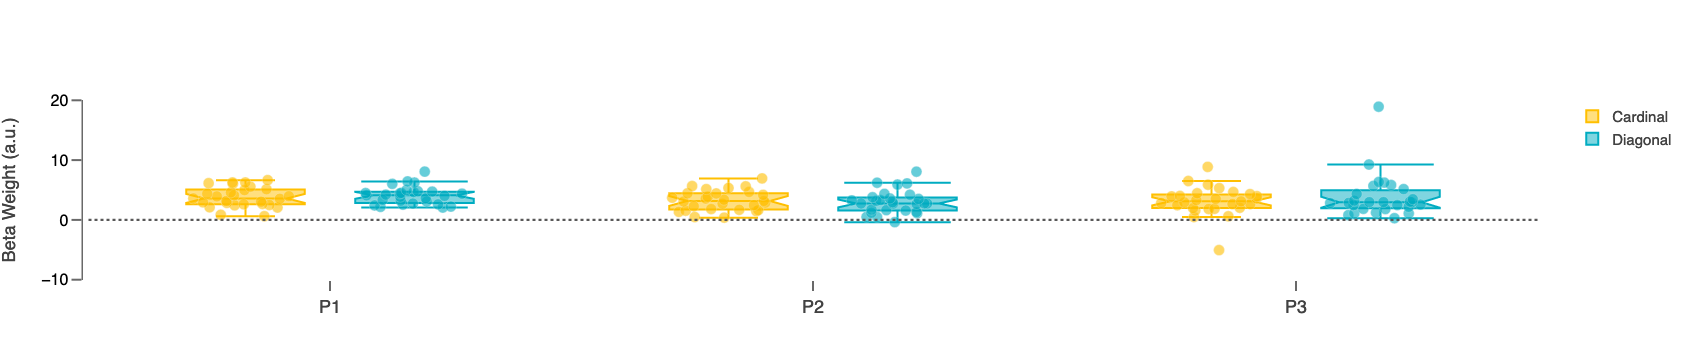

In [36]:
fig = go.Figure()

dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 0),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, 
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=  "#ffbf00"))

dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 1),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Diagonal', marker_color= '#00acc1'))

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, 
                 tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta Weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   ))


fig['layout']['yaxis'].update(range=[-10.05, 20.05]);

fig.show()

<font size="5"> _Figure 3C. PSE by presentation and condition._

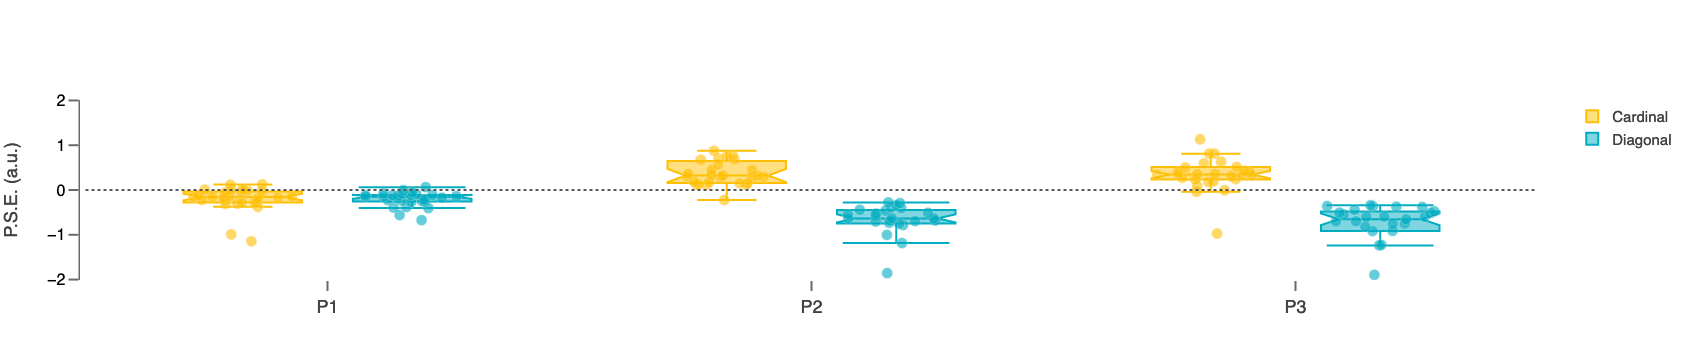

In [37]:
fig = go.Figure()

dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 0),:]
fig.add_trace(go.Box(y=dat['PSE'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color="#ffbf00"))

dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 1),:]
fig.add_trace(go.Box(y=dat['PSE'],x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Diagonal',marker_color='#00acc1'))

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="P.S.E. (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig['layout']['yaxis'].update(range=[-2.01, 2.01]);

fig.show()

<font size="5"> _Figure 4A. Beta Weight by presentation and sample._

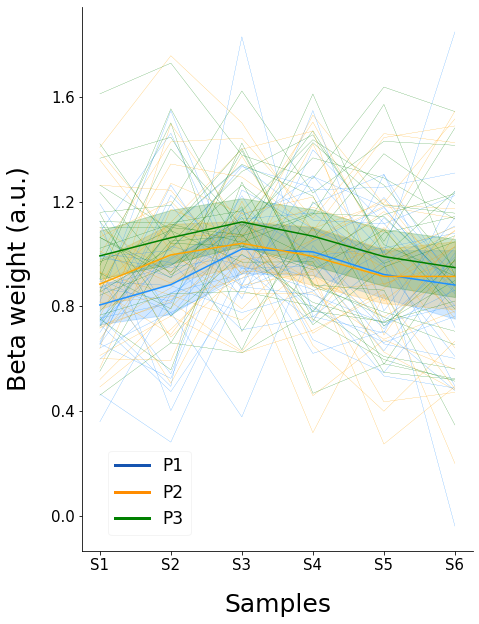

In [38]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
n_par_labels = np.unique(df.npar)

mycol = ["#1654B0", "darkorange", "g"]

for i in n_par_labels:
    dat= log_regstim_params.loc[log_regstim_params.npar ==i,:]
    sns.lineplot(x="stim", y="weight", hue="nrep", 
                 palette= ["dodgerblue", "orange", "green"], err_style=None,ci=95, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Weight', fontsize= 13)
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="stim", y="weight", hue="nrep",
             palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)

ind = ind = np.arange(6)
plt.ylabel('Beta weight (a.u.)', fontsize = 25, labelpad=20); 
plt.yticks(np.arange(0, 1.801, step=0.4), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); 
plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
labels = ['P1', 'P2', 'P3']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.3,0.2), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
plt.savefig('sample_weight4part.png',bbox_inches='tight')

<font size="4"> Statistical tests for Weight

In [39]:
# ANOVA to check if weight depends on the position of the stimuli sample: recency and primacy bias

pg.rm_anova(dv = 'weight', within = ['nrep', 'stim'], subject = 'npar', 
            data=log_regstim_params, detailed = True, correction = True)

C:\Users\Angel\Anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



Source        SS  ddof1  ddof2        MS          F     p-unc  \
0         nrep  1.030652      2     52  0.515326  11.935282  0.000054   
1         stim  1.673804      5    130  0.334761   2.600545  0.028160   
2  nrep * stim  0.293752     10    260  0.029375   1.657772  0.090945   

   p-GG-corr       np2       eps  
0   0.000143  0.314622  0.862338  
1   0.036363  0.090926  0.856880  
2   0.165352  0.059939  0.400615

In [40]:
# post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['nrep', 'stim'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=False, data=log_regstim_params) 

Contrast   A   B  Paired  Parametric         T   dof       Tail     p-unc  \
0      nrep   0   1    True        True -1.447206  26.0  two-sided  0.159790   
1      nrep   0   2    True        True -4.458136  26.0  two-sided  0.000140   
2      nrep   1   2    True        True -4.107599  26.0  two-sided  0.000353   
3      stim  d1  d2    True        True -1.582897  26.0  two-sided  0.125535   
4      stim  d1  d3    True        True -3.126167  26.0  two-sided  0.004323   
5      stim  d1  d4    True        True -2.322685  26.0  two-sided  0.028289   
6      stim  d1  d5    True        True -0.881893  26.0  two-sided  0.385915   
7      stim  d1  d6    True        True -0.378904  26.0  two-sided  0.707836   
8      stim  d2  d3    True        True -1.317111  26.0  two-sided  0.199292   
9      stim  d2  d4    True        True -0.831418  26.0  two-sided  0.413308   
10     stim  d2  d5    True        True  0.638178  26.0  two-sided  0.528939   
11     stim  d2  d6    True        True  1.078584  26.0  two-sided  0.290679   
12     stim  d3  d4    True        True  0.617253  26.0  two-sided  0.542436   
13     stim  d3  d5    True        True  2.039108  26.0  two-sided  0.051725   
14     stim  d3  d6    True        True  2.111032  26.0  two-sided  0.044541   
15     stim  d4  d5    True        True  1.567757  26.0  two-sided  0.129029   
16     stim  d4  d6    True        True  2.225504  26.0  two-sided  0.034931   
17     stim  d5  d6    True        True  0.557030  26.0  two-sided  0.582271   

      p-corr p-adjust     BF10     cohen  
0   0.479369     bonf    0.517 -0.216513  
1   0.000421     bonf  195.188 -0.653990  
2   0.001059     bonf   85.636 -0.361566  
3   1.000000     bonf    0.615 -0.363347  
4   0.064852     bonf    9.524 -0.767649  
5   0.424334     bonf    1.968 -0.547645  
6   1.000000     bonf     0.29 -0.199763  
7   1.000000     bonf    0.218 -0.075226  
8   1.000000     bonf    0.442 -0.339072  
9   1.000000     bonf    0.279 -0.165943  
10  1.000000     bonf    0.246  0.150680  
11  1.000000     bonf    0.345  0.230966  
12  1.000000     bonf    0.243  0.164454  
13  0.775881     bonf    1.212  0.500340  
14  0.668108     bonf    1.365  0.543819  
15  1.000000     bonf    0.603  0.317909  
16  0.523969     bonf    1.658  0.381356  
17  1.000000     bonf    0.235  0.095431

<font size="2"> _t-test showed that discriminabilty was larger in the third sample than in the first one._

<font size="5"> _Figure 4B. Intercept by presentation and sample._

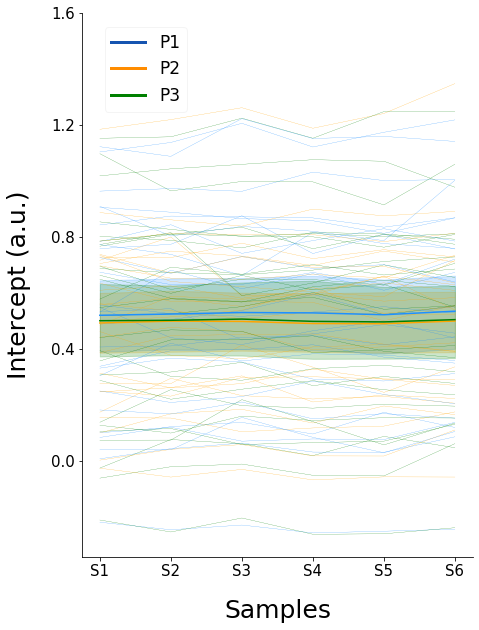

In [41]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
n_par_labels = np.unique(df.npar)#npar

mycol = ["#1654B0", "darkorange", "g"]

for i in n_par_labels:
    dat= log_regstim_params.loc[log_regstim_params.npar ==i,:]
    sns.lineplot(x="stim", y="intercept", hue="nrep", 
                 palette= ["dodgerblue", "orange", "green"], err_style=None,ci=95, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Intercept', fontsize= 13)
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="stim", y="intercept", hue="nrep",
             palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)

legend.remove()
ind = ind = np.arange(6)
plt.ylabel('Intercept (a.u.)', fontsize = 25, labelpad=20); 
plt.yticks(np.arange(0, 1.801, step=0.4), fontsize = 15) 
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); 
plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
labels = ['P1', 'P2', 'P3']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.29,0.99), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
plt.savefig('sample_intercept4part.png',bbox_inches='tight')

<font size="4"> Statistical tests for Inercept

In [42]:
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position

pg.rm_anova(dv = 'intercept', within = ['nrep', 'stim'], subject = 'npar', 
            data=log_regstim_params, detailed = True, correction = True)

C:\Users\Angel\Anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



Source        SS  ddof1  ddof2        MS         F     p-unc  \
0         nrep  0.090417      2     52  0.045209  0.781188  0.463160   
1         stim  0.006446      5    130  0.001289  0.297894  0.913301   
2  nrep * stim  0.002036     10    260  0.000204  0.887480  0.545433   

   p-GG-corr       np2       eps  
0   0.461256  0.029169  0.983005  
1   0.889364  0.011328  0.853684  
2   0.399370  0.033007  0.161823

<font size="2"> _There were non statisitcal differences in sample position and intercept._

<font size="5"> _Figure 5 A & B. Category similarity between consecutive samples._

Logisitc regression model with the category of the previous stimuli sample

In [43]:
# First, build a logistic model with presentations and the category of previous sample

formula = "deci ~ dv"

log_regpre_deci_params = dflong_sd.groupby(['npar', 'nrep', 'pre_stim']).apply(log_reg_fit, formula)
log_regpre_deci_params.reset_index(inplace = True)
log_regpre_deci_params.head()

npar  nrep  pre_stim  level_3  intercept    weight       PSE
0   1.0     0       0.0        0   0.573422  1.718918 -0.333595
1   1.0     0       1.0        0   0.756945  0.345226 -2.192608
2   1.0     1       0.0        0   0.675239  2.021990 -0.333948
3   1.0     1       1.0        0   0.663131  0.452032 -1.467000
4   1.0     2       0.0        0   0.655702  2.153356 -0.304502

<font size="5"> _5A. Beta Weight._

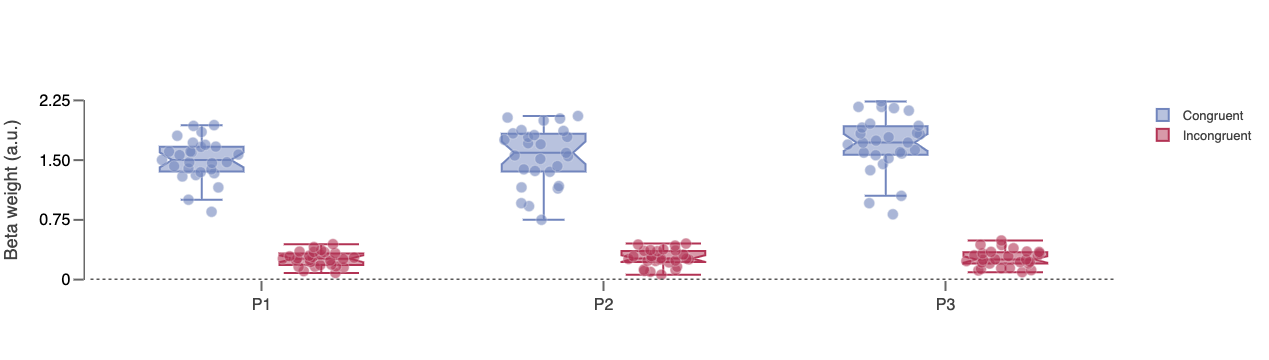

In [44]:
fig = go.Figure()
data = log_regpre_deci_params

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 0),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all', jitter=0.99, 
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#7185bd'))

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 1),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [0, .75, 1.50, 2.25], ticktext=['0', '0.75', '1.50', '2.25', '1', '1.25'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",size=15, color= "#424242" ))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.005, 2.255])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [45]:
#Checking statistical differences in Weight between the number of repetitions & the previous sample category
# If there are differences after adreesing the ANOVA, the differences that we saw at the plot are significant

pg.rm_anova(dv = 'weight', within = ['pre_stim','nrep'], subject = 'npar', 
            data=log_regpre_deci_params, detailed = True, correction = True)

#Weight was larger in those samples that followed a sample from the same category

Source         SS  ddof1  ddof2         MS           F  \
0         pre_stim  71.094337      1     26  71.094337  483.334658   
1             nrep   0.290875      2     52   0.145437    9.591266   
2  pre_stim * nrep   0.269421      2     52   0.134711   12.513375   

          p-unc     p-GG-corr       np2       eps  
0  2.537681e-18  2.537681e-18  0.948953  1.000000  
1  2.846935e-04  5.630018e-04  0.269484  0.876950  
2  3.659367e-05  4.247922e-05  0.324910  0.979889

Post-hoc t-test

In [46]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['pre_stim','nrep'], subject='npar', 
                   padjust='bonf', effsize = 'cohen',interaction=False, data=log_regpre_deci_params) 

Contrast    A    B  Paired  Parametric          T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  21.984873  26.0  two-sided   
1      nrep  0.0  1.0    True        True  -1.128137  26.0  two-sided   
2      nrep  0.0  2.0    True        True  -4.334441  26.0  two-sided   
3      nrep  1.0  2.0    True        True  -3.572167  26.0  two-sided   

          p-unc    p-corr p-adjust       BF10     cohen  
0  2.537681e-18       NaN      NaN  1.705e+15  5.868905  
1  2.695651e-01  0.808695     bonf      0.362 -0.181398  
2  1.945922e-04  0.000584     bonf    145.735 -0.617947  
3  1.411445e-03  0.004234     bonf     25.168 -0.358049

In [47]:
# post-hoc t-test for P1
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 0] 
pg.pairwise_ttests(dv='weight', within=['pre_stim'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  22.94958  26.0  two-sided   

          p-unc       BF10     cohen  
0  8.758731e-19  4.721e+15  6.459449

In [48]:
# post-hoc t-test for P2
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 1] 
pg.pairwise_ttests(dv='weight', within=['pre_stim'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

Contrast    A    B  Paired  Parametric          T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  19.075353  26.0  two-sided   

          p-unc       BF10     cohen  
0  8.257958e-17  6.085e+13  4.822341

In [49]:
# post-hoc t-test for P3
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 2] 
pg.pairwise_ttests(dv='weight', within=['pre_stim'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

Contrast    A    B  Paired  Parametric          T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  20.411105  26.0  two-sided   

          p-unc       BF10     cohen  
0  1.580512e-17  2.959e+14  5.437107

In [50]:
dat = log_regpre_deci_params.loc[log_regpre_deci_params.pre_stim == 0]
pg.pairwise_ttests(dv='weight', within=['nrep'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -1.210458  26.0  two-sided  0.236993   
1     nrep  0  2    True        True -4.824389  26.0  two-sided  0.000053   
2     nrep  1  2    True        True -3.893613  26.0  two-sided  0.000617   

     p-corr p-adjust     BF10     cohen  
0  0.710978     bonf    0.394 -0.171099  
1  0.000160     bonf  466.624 -0.631159  
2  0.001850     bonf   52.184 -0.396395

In [51]:
dat = log_regpre_deci_params.loc[log_regpre_deci_params.pre_stim == 1]
pg.pairwise_ttests(dv='weight', within=['nrep'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -0.475694  26.0  two-sided  0.638265   
1     nrep  0  2    True        True -0.305452  26.0  two-sided  0.762454   
2     nrep  1  2    True        True  0.193295  26.0  two-sided  0.848230   

   p-corr p-adjust   BF10     cohen  
0     1.0     bonf  0.226 -0.080480  
1     1.0     bonf  0.213 -0.056762  
2     1.0     bonf  0.207  0.022137

<font size="5"> _5B. Intercept._

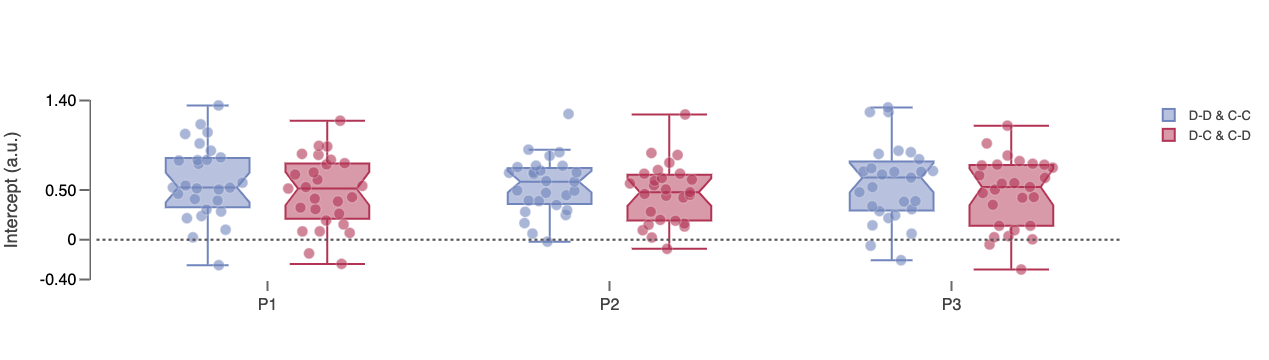

In [52]:
fig = go.Figure()
data = log_regpre_deci_params
dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],x=dat['nrep'],boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='D-D & C-C', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#7185bd')) 

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['intercept'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='D-C & C-D', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-.40, 0.50, 1.4, 0], ticktext=['-0.40', '0.50', '1.40', '0', '0.80' ,'1.20', '1.40'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif",size=15,color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.405, 1.405])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, 
              line=dict(color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Inercept

In [53]:
#Checking statistical differences in Intercept between the number of repetitions 
# & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_stim'], subject = 'npar', 
            data=log_regpre_deci_params, detailed = True, correction = True)

# no differences in the intercept

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0             nrep  0.020666      2     52  0.010333  0.516653  0.599543   
1         pre_stim  0.349316      1     26  0.349316  8.969096  0.005960   
2  nrep * pre_stim  0.005757      2     52  0.002878  0.762662  0.471569   

   p-GG-corr       np2       eps  
0   0.598899  0.019484  0.996376  
1   0.005960  0.256486  1.000000  
2   0.460285  0.028497  0.907134

In [54]:
pg.pairwise_ttests(dv='intercept', within=['pre_stim', 'nrep'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=log_regpre_deci_params) 

Contrast pre_stim  A  B Paired  Parametric         T   dof  \
0         pre_stim        -  0  1   True        True  2.994845  26.0   
1             nrep        -  0  1   True        True  0.977335  26.0   
2             nrep        -  0  2   True        True  0.649050  26.0   
3             nrep        -  1  2   True        True -0.373029  26.0   
4  pre_stim * nrep        0  0  1   True        True  1.271739  26.0   
5  pre_stim * nrep        0  0  2   True        True  0.815741  26.0   
6  pre_stim * nrep        0  1  2   True        True -0.532817  26.0   
7  pre_stim * nrep        1  0  1   True        True  0.447472  26.0   
8  pre_stim * nrep        1  0  2   True        True  0.344832  26.0   
9  pre_stim * nrep        1  1  2   True        True -0.118930  26.0   

        Tail     p-unc  p-corr p-adjust   BF10     cohen  
0  two-sided  0.005960     NaN      NaN  7.235  0.278307  
1  two-sided  0.337410     1.0     bonf  0.314  0.085460  
2  two-sided  0.521999     1.0     bonf  0.247  0.048439  
3  two-sided  0.712151     1.0     bonf  0.217 -0.031116  
4  two-sided  0.214724     1.0     bonf   0.42  0.126499  
5  two-sided  0.422059     1.0     bonf  0.276  0.064534  
6  two-sided  0.598686     1.0     bonf  0.232 -0.050571  
7  two-sided  0.658240     1.0     bonf  0.223  0.038672  
8  two-sided  0.732995     1.0     bonf  0.215  0.027723  
9  two-sided  0.906245     1.0     bonf  0.205 -0.008887

In [55]:
# post-hoc t-test for P1

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==0]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  3.001301  26.0  two-sided   

      p-unc   BF10     cohen  
0  0.005867  7.332  0.294823

In [56]:
# post-hoc t-test for P2

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==1]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  2.830166  26.0  two-sided   

      p-unc   BF10     cohen  
0  0.008852  5.168  0.267804

In [57]:
# post-hoc t-test for P3

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==2]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  2.483398  26.0  two-sided   

      p-unc   BF10     cohen  
0  0.019786  2.638  0.248507

<font size="5"> _Figure 5 C & D. Physical similarity between consecutive samples._

<font size="5"> _5C. Beta Weight._

Logisitc regression model with the physical similarity with previous sample

In [58]:
formula = "deci ~ dv"

log_regpre_orient_params = dflong_sd.groupby(['npar', 'nrep', 'pre_orient']).apply(log_reg_fit, formula)
log_regpre_orient_params.reset_index(inplace = True)
log_regpre_orient_params.head()

npar  nrep  pre_orient  level_3  intercept    weight       PSE
0   1.0     0         0.0        0   0.637235  1.162560 -0.548131
1   1.0     0         1.0        0   0.682680  1.197027 -0.570313
2   1.0     1         0.0        0   0.660009  1.236967 -0.533571
3   1.0     1         1.0        0   0.697869  1.546559 -0.451240
4   1.0     2         0.0        0   0.681061  1.285929 -0.529626

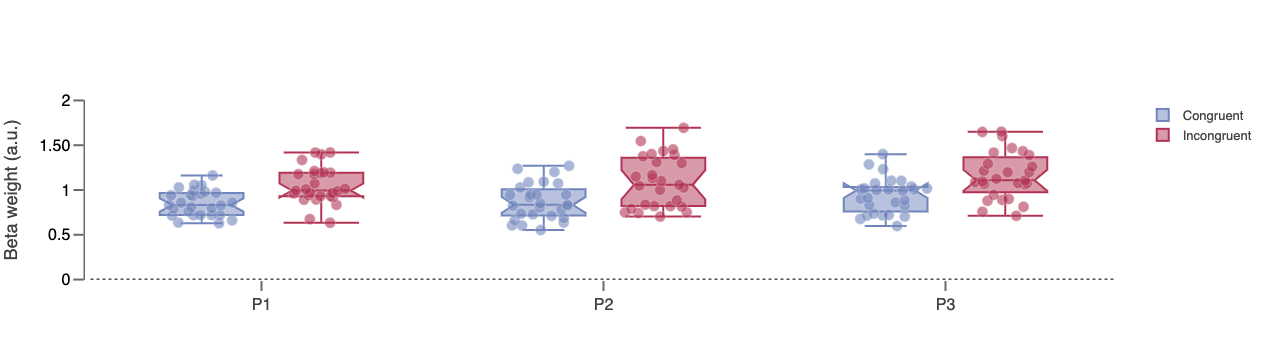

In [59]:
# Stimulus following one similar orientated (do not differ in many degrees) are weighted less than others
# preceded by stimuli from distant orientations.

fig = go.Figure()
data = log_regpre_orient_params

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another similar oriented
    y=dat['weight'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#3FBFAA', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli followed by another similar in orientation
    marker_color='#7185bd'))

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box( #condition for samples that follow stimuli pysichaly similar
    y=dat['weight'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#9F68E3', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli followed by another very different in orientation
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [0, .5, 1, 1.50, 2], ticktext=['0', '0.5', '1', '1.50', '2'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.005, 2.005])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [60]:
# Checking statistical differences in 
# Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'weight', within = ['nrep', 'pre_orient'], subject = 'npar', 
            data=log_regpre_orient_params, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS          F     p-unc  \
0               nrep  0.277075      2     52  0.138537   9.507513  0.000303   
1         pre_orient  1.834391      1     26  1.834391  39.441045  0.000001   
2  nrep * pre_orient  0.006224      2     52  0.003112   0.454455  0.637291   

   p-GG-corr       np2       eps  
0   0.000603  0.267761  0.874322  
1   0.000001  0.602696  1.000000  
2   0.626807  0.017179  0.946761

In [61]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['nrep', 'pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=log_regpre_orient_params) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0        nrep  0.0  1.0    True        True -1.125617  26.0  two-sided   
1        nrep  0.0  2.0    True        True -4.335024  26.0  two-sided   
2        nrep  1.0  2.0    True        True -3.548843  26.0  two-sided   
3  pre_orient  0.0  1.0    True        True -6.280211  26.0  two-sided   

      p-unc    p-corr p-adjust       BF10     cohen  
0  0.270611  0.811834     bonf      0.361 -0.160350  
1  0.000194  0.000583     bonf    145.935 -0.542633  
2  0.001498  0.004494     bonf     23.891 -0.316516  
3  0.000001       NaN      NaN  1.503e+04 -1.044517

Post-hoc t-test to look for interactions within categories

In [62]:
# post-hoc t-test for P1

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 0]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_orient  0.0  1.0    True        True -5.305021  26.0  two-sided   

      p-unc      BF10     cohen  
0  0.000015  1474.949 -1.105405

In [63]:
# post-hoc t-test for P2

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 1]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_orient  0.0  1.0    True        True -5.316472  26.0  two-sided   

      p-unc      BF10     cohen  
0  0.000015  1515.975 -0.893998

In [64]:
# post-hoc t-test for P3

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 2]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_orient  0.0  1.0    True        True -5.988884  26.0  two-sided   

      p-unc      BF10     cohen  
0  0.000003  7548.418 -0.959297

<font size="5"> _5D. Intercept._

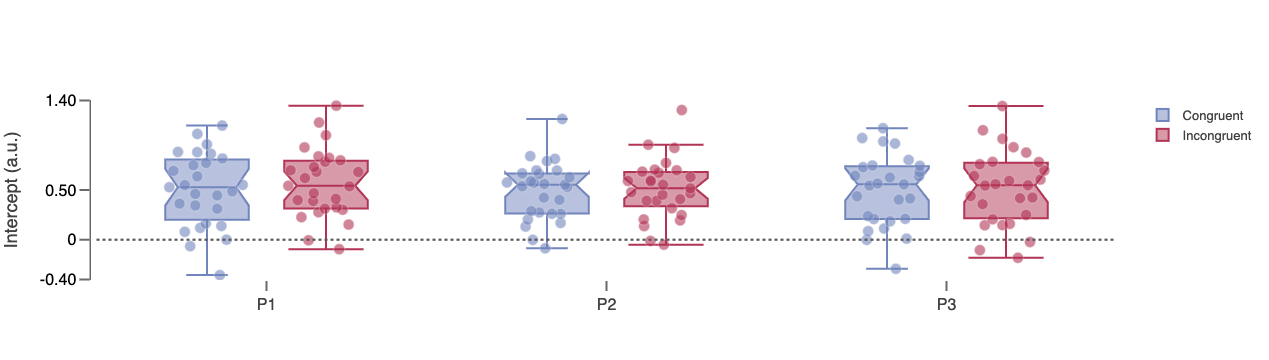

In [65]:
fig = go.Figure()

data = log_regpre_orient_params
dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]

fig.add_trace(go.Box(
    y=dat['intercept'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#3FBFAA',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli followed by another pyshically similar
    marker_color='#7185bd'))

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box(
    y=dat['intercept'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4) ),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli followed by another very different in orientation
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-.40, 0.50, 1.4, 0], ticktext=['-0.40', '0.50', '1.40', '0', '0.80' ,'1.20', '1.40'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.405, 1.405])
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Intercept

In [66]:
#statistical test in Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_orient'], subject = 'npar', 
            data=log_regpre_orient_params, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0               nrep  0.039290      2     52  0.019645  1.015189  0.369402   
1         pre_orient  0.055587      1     26  0.055587  2.131919  0.156239   
2  nrep * pre_orient  0.018495      2     52  0.009247  2.246483  0.115940   

   p-GG-corr       np2       eps  
0   0.369034  0.037578  0.993656  
1   0.156239  0.075783  1.000000  
2   0.123065  0.079531  0.881712

<font size="5"> _Supplementary Figure 1A. Beta Weight for physical similarity between stimuli samples and previous decisions._

Logisitc regression model with congruency with stimuli sample by each presentation

In [67]:
formula = "deci ~ dv"
log_reg_cong_stim = dflong.groupby(['npar', 'cong_stim', 'nrep', 'cond']).apply(log_reg_fit, formula) 
log_reg_cong_stim.reset_index(inplace = True)
log_reg_cong_stim.head()

npar cong_stim  nrep cond  level_4  intercept    weight       PSE
0   1.0         C     0    C        0   0.424701  0.699207 -0.607404
1   1.0         C     0    D        0   0.528305  1.250253 -0.422559
2   1.0         C     1    C        0  -0.509355  0.231463  2.200588
3   1.0         C     1    D        0   1.857974  0.530428 -3.502782
4   1.0         C     2    C        0  -0.400884  0.455135  0.880802

In [68]:
looking_outliers = log_reg_cong_stim.loc[log_reg_cong_stim.nrep == 2]
looking_outliers.tail(6)

npar cong_stim  nrep cond  level_4  intercept    weight       PSE
310  29.0         I     2    C        0   1.659279  0.205929 -8.057531
311  29.0         I     2    D        0   0.223581 -0.344354  0.649278
316  30.0         C     2    C        0  -0.217963  0.894714  0.243612
317  30.0         C     2    D        0   1.516143 -0.321475  4.716204
322  30.0         I     2    C        0   1.196486  0.633313 -1.889248
323  30.0         I     2    D        0  -0.418826 -0.084138 -4.977873

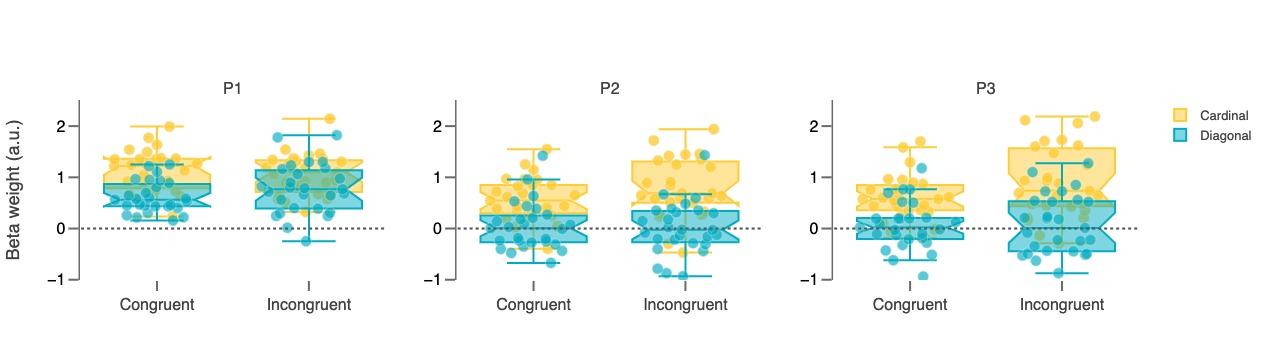

In [69]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], opacity = 0.8, x=dat['cong_stim'], boxpoints='all',
    jitter=.99, pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( y=dat['weight'], x=dat['cong_stim'], opacity = 1, showlegend=False, boxpoints='all',
    jitter=.99, pointpos=0, marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal', marker_color='#00acc1'), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color='  #ffbf00  '), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_stim'], opacity = 1, boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=2)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(  y=dat['weight'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', 
    marker_color=' #ffbf00 '), row=1, col=3) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( 
    y=dat['weight'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_yaxes(showgrid=False)

fig.update_layout(yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))
fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.005, 2.51]); fig['layout']['yaxis2'].update(range=[-1.005, 2.51])
fig['layout']['yaxis3'].update(range=[-1.005, 2.51])

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [70]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'C']
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_stim'], subject = 'npar', data=dat, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS          F  \
0              nrep  5.062851      2     52  2.531426  21.660436   
1         cong_stim  0.924976      1     26  0.924976   2.971054   
2  nrep * cong_stim  0.938676      2     52  0.469338   3.764860   

          p-unc     p-GG-corr       np2       eps  
0  1.436146e-07  1.591263e-07  0.454474  0.991891  
1  9.664012e-02  9.664012e-02  0.102553  1.000000  
2  2.971714e-02  4.003669e-02  0.126487  0.803963

In [71]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.pairwise_ttests(dv='weight', within= ['nrep', 'cong_stim'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast nrep  A  B Paired  Parametric          T   dof       Tail  \
0              nrep    -  0  1   True        True  11.070187  26.0  two-sided   
1              nrep    -  0  2   True        True   8.199577  26.0  two-sided   
2              nrep    -  1  2   True        True  -0.839986  26.0  two-sided   
3         cong_stim    -  C  I   True        True  -0.430513  26.0  two-sided   
4  nrep * cong_stim    0  C  I   True        True  -1.305173  26.0  two-sided   
5  nrep * cong_stim    1  C  I   True        True   0.286044  26.0  two-sided   
6  nrep * cong_stim    2  C  I   True        True  -0.097211  26.0  two-sided   

          p-unc        p-corr p-adjust       BF10     cohen  
0  2.450018e-11  7.350053e-11     bonf  3.736e+08  2.233195  
1  1.110960e-08  3.332881e-08     bonf  1.173e+06  1.874948  
2  4.085745e-01  1.000000e+00     bonf      0.281 -0.120581  
3  6.703707e-01           NaN      NaN      0.222 -0.115840  
4  2.032672e-01  6.098015e-01     bonf      0.437 -0.382671  
5  7.771112e-01  1.000000e+00     bonf      0.212  0.081996  
6  9.233044e-01  1.000000e+00     bonf      0.205 -0.025444

In [72]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cong_stim == 'C'),:]
pg.rm_anova(dv = 'weight', within = ['cond'], subject = 'npar', data=dat, detailed = True, correction = True)

Source        SS  DF        MS          F     p-unc       np2  eps
0   cond  3.517647   1  3.517647  19.769313  0.000145  0.431934  1.0
1  Error  4.626302  26  0.177935        NaN       NaN       NaN  NaN

<font size="5"> _Supplementary Figure 1B. Intercept for Physical similarity between stimuli samples and previous decisions._

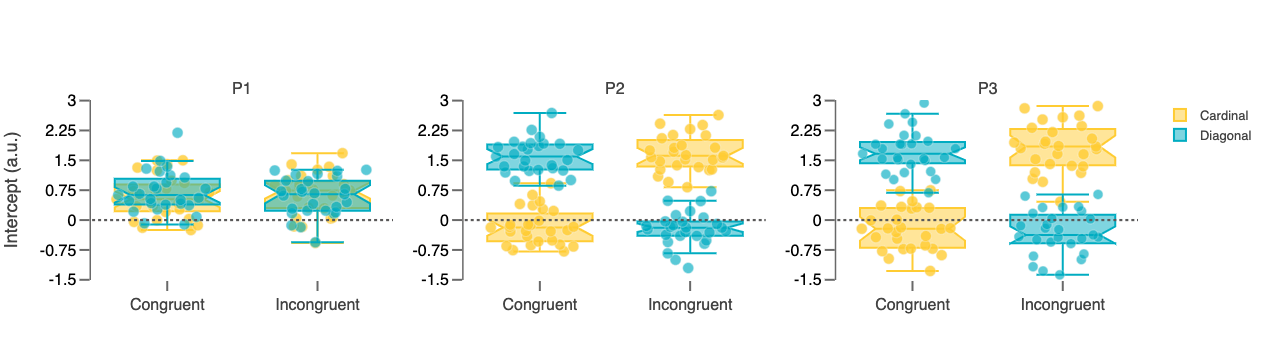

In [73]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box( 
    y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color='  #ffbf00  '), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_stim'], opacity = 1, boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box( 
    y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal',
    marker_color=' #ffbf00 '), row=1, col=3) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( y=dat['intercept'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=10,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.5,-0.75, 0, 0.75, 1.5, 2.25, 3], 
                 ticktext=['-1.5','-0.75', '0', '0.75', '1.5' ,'2.25', '3'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.505, 3.015]); fig['layout']['yaxis2'].update(range=[-1.505, 3.015])
fig['layout']['yaxis3'].update(range=[-1.505, 3.015],)

fig.show()

<font size="4"> Statistical tests for Intercept

In [74]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_stim'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

Source         SS  ddof1  ddof2         MS           F  \
0              nrep   0.106604      2     52   0.053302    1.405071   
1         cong_stim  71.439302      1     26  71.439302  342.787419   
2  nrep * cong_stim  29.185073      2     52  14.592537  194.679087   

          p-unc     p-GG-corr       np2       eps  
0  2.545089e-01  2.548169e-01  0.051270  0.932192  
1  1.704312e-16  1.704312e-16  0.929499  1.000000  
2  7.104220e-25  8.008772e-21  0.882182  0.820243

In [75]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_stim'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast nrep  A  B Paired  Parametric          T   dof       Tail  \
0              nrep    -  0  1   True        True  -1.423697  26.0  two-sided   
1              nrep    -  0  2   True        True  -1.466176  26.0  two-sided   
2              nrep    -  1  2   True        True  -0.365952  26.0  two-sided   
3         cong_stim    -  C  I   True        True  18.514519  26.0  two-sided   
4  nrep * cong_stim    0  C  I   True        True   1.250214  26.0  two-sided   
5  nrep * cong_stim    1  C  I   True        True  21.684017  26.0  two-sided   
6  nrep * cong_stim    2  C  I   True        True  22.650209  26.0  two-sided   

          p-unc        p-corr p-adjust       BF10     cohen  
0  1.664252e-01  4.992756e-01     bonf      0.502 -0.117921  
1  1.545916e-01  4.637747e-01     bonf      0.529 -0.133234  
2  7.173619e-01  1.000000e+00     bonf      0.217 -0.032899  
3  1.704312e-16           NaN      NaN  3.044e+13  2.954235  
4  2.223572e-01  6.670715e-01     bonf      0.411  0.268860  
5  3.566698e-18  1.070009e-17     bonf   1.23e+15  4.279840  
6  1.213097e-18  3.639292e-18     bonf  3.456e+15  3.767159

<font size="5"> _Figure 6A. Beta Weight for Categorical similarity between stimuli samples and previous decisions._

<font size="3"> _Logisitc regression model to plot Figure 6_

In [76]:
formula = "deci ~ dv"
log_reg_cong_deci = dflong.groupby(['npar', 'cong_deci', 'nrep', 'cond']).apply(log_reg_fit, formula) 
log_reg_cong_deci.reset_index(inplace = True)
log_reg_cong_deci.head()

npar cong_deci  nrep cond  level_4  intercept    weight       PSE
0   1.0         C     0    C        0   0.195054  0.571804 -0.341120
1   1.0         C     0    D        0   0.530885  1.448131 -0.366600
2   1.0         C     1    C        0  -1.567359  0.202153  7.753317
3   1.0         C     1    D        0   1.644346  1.427259 -1.152101
4   1.0         C     2    C        0  -1.282753  0.670489  1.913161

Figure 6A

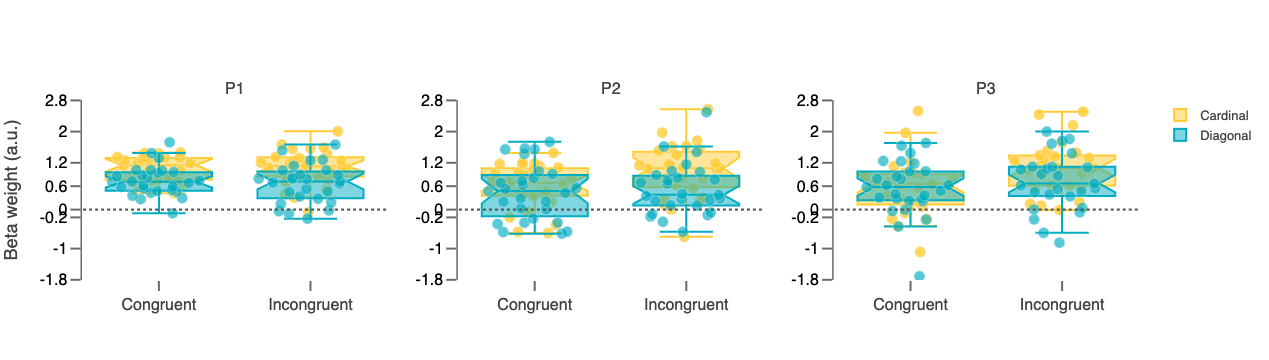

In [77]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', 
    marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99,
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal',
    marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'D'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99,
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=True, opacity = 0.8,
    boxpoints='all', jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'D'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all', jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.65, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.8, -1, -.2, 0, 0.6, 1.2, 2, 2.8], 
                 ticktext=['-1.8','-1', '-0.2', '0', '0.6' ,'1.2', '2', '2.8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.805, 2.81]); fig['layout']['yaxis2'].update(range=[-1.805, 2.81])
fig['layout']['yaxis3'].update(range=[-1.805, 2.81])

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [78]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0              nrep  2.249762      2     52  1.124881  4.725408  0.013013   
1         cong_deci  3.756905      1     26  3.756905  8.257388  0.007982   
2  nrep * cong_deci  1.637936      2     52  0.818968  2.925429  0.062522   

   p-GG-corr       np2       eps  
0   0.017580  0.153795  0.862711  
1   0.007982  0.241040  1.000000  
2   0.066848  0.101137  0.929404

In [79]:
dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2),:]
pg.pairwise_ttests(dv='weight', within= ['cond', 'cong_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast cond  A  B Paired  Parametric         T   dof       Tail  \
0              cond    -  C  D   True        True  1.041703  26.0  two-sided   
1         cong_deci    -  C  I   True        True -2.255165  26.0  two-sided   
2  cond * cong_deci    C  C  I   True        True -2.574830  26.0  two-sided   
3  cond * cong_deci    D  C  I   True        True -1.132627  26.0  two-sided   

      p-unc    p-corr p-adjust   BF10     cohen  
0  0.307139       NaN      NaN  0.333  0.262851  
1  0.032768       NaN      NaN  1.746 -0.649987  
2  0.016072  0.032143     bonf  3.134 -0.712635  
3  0.267708  0.535417     bonf  0.363 -0.333281

In [80]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']
pg.pairwise_ttests(dv='weight', within= ['nrep', 'cong_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0       nrep  0  1    True        True  1.954473  26.0  two-sided  0.061479   
1       nrep  0  2    True        True -0.003172  26.0  two-sided  0.997493   
2       nrep  1  2    True        True -1.738290  26.0  two-sided  0.093991   
3  cong_deci  C  I    True        True -0.926794  26.0  two-sided  0.362557   

     p-corr p-adjust   BF10     cohen  
0  0.184437     bonf  1.058  0.499663  
1  1.000000     bonf  0.204 -0.000868  
2  0.281973     bonf  0.763 -0.377056  
3       NaN      NaN  0.301 -0.234961

<font size="5"> _Figure 6B. Intercept for Categorical similarity between stimuli samples and previous decisions._

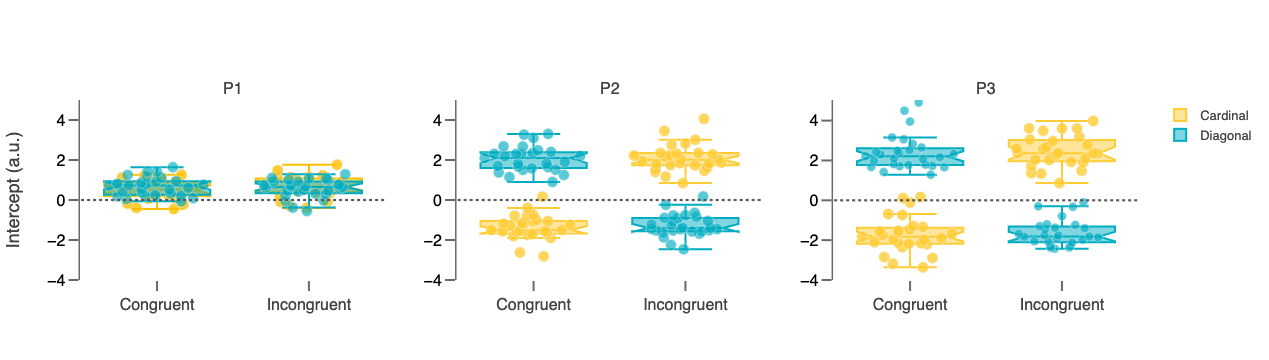

In [81]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')

fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=True, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal',marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=9,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))
fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(yaxis_title="Intercept (a.u.)", 
                  font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", 
                              font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-4, 5]); fig['layout']['yaxis2'].update(range=[-4, 5])
fig['layout']['yaxis3'].update(range=[-4, 5.034])

fig.show()

<font size="4"> Statistical tests for Intercept

In [82]:
# Cardinal condition
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']

pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

Source          SS  ddof1  ddof2          MS           F  \
0              nrep    1.636823      2     52    0.818411    4.140423   
1         cong_deci  275.743248      1     26  275.743248  258.756344   
2  nrep * cong_deci  124.524859      2     52   62.262430  168.648626   

          p-unc     p-GG-corr       np2       eps  
0  2.144984e-02  2.596399e-02  0.137371  0.892744  
1  4.966187e-15  4.966187e-15  0.908694  1.000000  
2  1.856830e-23  1.277561e-16  0.866426  0.676656

In [83]:
# Diagonal condition
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']

pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

Source          SS  ddof1  ddof2          MS           F  \
0              nrep    3.436114      2     52    1.718057    7.362840   
1         cong_deci  265.394084      1     26  265.394084  205.854769   
2  nrep * cong_deci  128.269370      2     52   64.134685   96.189332   

          p-unc     p-GG-corr       np2       eps  
0  1.529215e-03  2.454520e-03  0.220690  0.882641  
1  7.261261e-14  7.261261e-14  0.887861  1.000000  
2  3.360791e-18  5.051936e-13  0.787215  0.674975

In [84]:
dat1 = dat.loc[dat.nrep==2]
np.mean(dat1.intercept)

0.27519521493992277

In [85]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_deci'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric          T   dof       Tail  \
0       nrep  0  1    True        True   2.396753  26.0  two-sided   
1       nrep  0  2    True        True   3.051665  26.0  two-sided   
2       nrep  1  2    True        True   0.004395  26.0  two-sided   
3  cong_deci  C  I    True        True -16.085905  26.0  two-sided   

          p-unc    p-corr p-adjust       BF10     cohen  
0  2.402315e-02  0.072069     bonf      2.249  0.557865  
1  5.189772e-03  0.015569     bonf      8.143  0.501211  
2  9.965272e-01  1.000000     bonf      0.204  0.001052  
3  4.966187e-15       NaN      NaN  1.215e+12 -4.983536

<font size="5"> _Figure 7. β Weight by Incongruent Samples minus β Weight by Congruent Samples divided by Ambiguous and Unambiguous samples and by Conditions._

- Ambiguous (DV = -0.3 to 0.3)
- Unambiguous (DV = 1 to -0.3 and 0.3 to 1)

<font size="3"> _Logisitc regression model to plot Figure 7_

In [86]:
new_dflong = dflong
new_dflong = new_dflong.loc[new_dflong.npar != 24,:] #this participants has not data for small bins

n_par = np.unique(new_dflong.npar)   #pre_deci
n_bins= np.array([-0.60, 0, 0.60])
log_reg_cong_bins = pd.DataFrame([]) # concatenate participants

formula = "deci ~ dv"
for i in n_par:
    newdf = new_dflong.loc[(new_dflong.npar == i),:]
    for j in n_bins:
        newdf2 = newdf.loc[(newdf.bins == j),:]
        log_reg = newdf2.groupby(['npar', 'nrep', 'cond', 'cong_deci', 'bins']).apply(log_reg_fit, formula)
        log_reg_cong_bins = pd.concat([log_reg_cong_bins, log_reg], axis = 0)
    
log_reg_cong_bins.reset_index(inplace = True)
log_reg_cong_bins.head(10)

npar  nrep cond cong_deci bins  level_5  intercept    weight       PSE
0   1.0     0    C         C -0.6        0   0.202001  0.478565 -0.422097
1   1.0     0    C         I -0.6        0   0.585941  0.970050 -0.604031
2   1.0     1    C         C -0.6        0  -0.831635  1.202241  0.691737
3   1.0     1    C         I -0.6        0   1.853114  1.028917 -1.801034
4   1.0     2    C         C -0.6        0  -1.451881  0.402832  3.604187
5   1.0     2    C         I -0.6        0   1.947116  0.957039 -2.034521
6   1.0     0    C         C  0.0        0   0.232816  1.057217 -0.220216
7   1.0     0    C         I  0.0        0   0.901060  0.924804 -0.974325
8   1.0     0    D         C  0.0        0   0.296233  1.780832 -0.166345
9   1.0     0    D         I  0.0        0   0.991398 -1.183951  0.837364

In [87]:
# first step: coding the new necessary variables  
# to substract β Weight in Congruent Samples to β Weight in Incongruent Samples

log_reg_cong_bins.insert(7,'intercept-1', 0)
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept']
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept-1'].shift(1, fill_value = 0)

log_reg_cong_bins.insert(9,'weight-1', 0)
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight']
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight-1'].shift(1, fill_value = 0)

log_reg_cong_bins.insert(8, 'bias', 0)
log_reg_cong_bins['bias'] = log_reg_cong_bins['intercept'] - log_reg_cong_bins['intercept-1']

log_reg_cong_bins.insert(10, 'slope', 0)
log_reg_cong_bins['slope'] = log_reg_cong_bins['weight'] - log_reg_cong_bins['weight-1']
log_reg_cong_bins.head()

npar  nrep cond cong_deci bins  level_5  intercept  intercept-1      bias  \
0   1.0     0    C         C -0.6        0   0.202001     0.000000  0.202001   
1   1.0     0    C         I -0.6        0   0.585941     0.202001  0.383939   
2   1.0     1    C         C -0.6        0  -0.831635     0.585941 -1.417575   
3   1.0     1    C         I -0.6        0   1.853114    -0.831635  2.684748   
4   1.0     2    C         C -0.6        0  -1.451881     1.853114 -3.304995   

     weight     slope  weight-1       PSE  
0  0.478565  0.478565  0.000000 -0.422097  
1  0.970050  0.491485  0.478565 -0.604031  
2  1.202241  0.232191  0.970050  0.691737  
3  1.028917 -0.173324  1.202241 -1.801034  
4  0.402832 -0.626085  1.028917  3.604187

In [88]:
# second step: drop unnecessary columns 
log_reg_cong_bins = log_reg_cong_bins.loc[(log_reg_cong_bins.cong_deci == 'I'),:]
log_reg_cong_bins = log_reg_cong_bins.drop(columns=['intercept-1', 'intercept', 'cong_deci', 
                                                    'weight', 'weight-1', 'PSE', 'level_5'])
log_reg_cong_bins.head()

npar  nrep cond bins      bias     slope
1   1.0     0    C -0.6  0.383939  0.491485
3   1.0     1    C -0.6  2.684748 -0.173324
5   1.0     2    C -0.6  3.398996  0.554207
7   1.0     0    C  0.0  0.668244 -0.132413
9   1.0     0    D  0.0  0.695165 -2.964783

In [89]:
# third step: convert the variable "bins" in a categorical variable
log_reg_cong_bins["bins"] = log_reg_cong_bins["bins"].replace([-0.6, 0, 0.6], ['not_ambigu', 'ambigu', 'not_ambigu'])
log_reg_cong_bins.head()

npar  nrep cond        bins      bias     slope
1   1.0     0    C  not_ambigu  0.383939  0.491485
3   1.0     1    C  not_ambigu  2.684748 -0.173324
5   1.0     2    C  not_ambigu  3.398996  0.554207
7   1.0     0    C      ambigu  0.668244 -0.132413
9   1.0     0    D      ambigu  0.695165 -2.964783

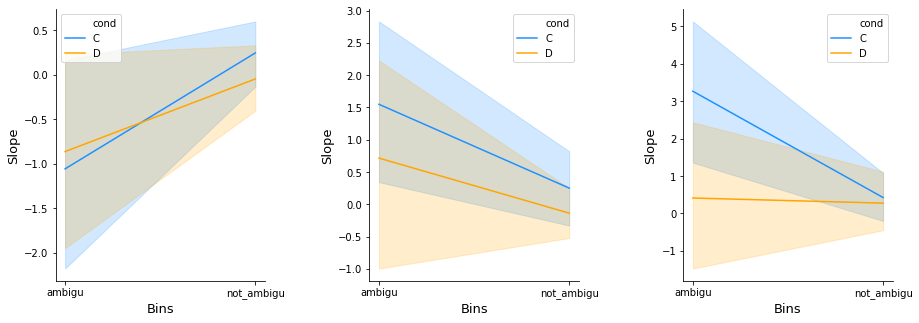

In [90]:
plt.subplots(ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5) #wspace previous 0.5

plt.subplot(1, 3, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==0),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==1),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 3)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==2),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

sns.despine(top=True)

In [91]:
# final step: plot the data
from plotly.subplots import make_subplots
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')

fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box(y=dat['slope'], opacity = 0.8, x=dat['bins'], boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], boxpoints='all', showlegend=False, opacity = 1,
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0, marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=3) 

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Unambiguous', 'Ambiguous'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-12,-8, -4, 0, 4, 8, 12, 16, 20], 
                 ticktext=['-12','-8', '-4', '0', '4' ,'8', '12', '16', '20'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(yaxis_title="Beta weight Incong. - Beta weight Cong. (a.u.)",
    font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif", size=13, color="#424242")))

fig['layout']['yaxis1'].update(range=[-12.05, 20.1]); fig['layout']['yaxis2'].update(range=[-12.05, 20.1])
fig['layout']['yaxis3'].update(range=[-12.05, 20.1])

fig.show()

<font size="4"> _Statistical tests_

Test whether differences in weight between congruent and incongruent samples with previous decisions depend by the ambiguity of the stimuli sample. 

<font size="2"> _t-test for unambiguous_

In [92]:
# t test for Cardinal, unambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test  1.2429   25  two-sided  0.2254  [-0.16, 0.64]   0.2438  0.413  0.2231

In [93]:
# t test for Cardinal, unambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test  0.8903   25  two-sided  0.3818  [-0.33, 0.83]   0.1746  0.297  0.1373

In [94]:
# t test for Cardinal, unambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test  1.2598   25  two-sided  0.2194  [-0.27, 1.12]   0.2471  0.421  0.2279

In [95]:
# t test for Diagonal, unambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test -0.2522   25  two-sided  0.8029  [-0.45, 0.35]   0.0495  0.213  0.0568

In [96]:
# t test for Diagonal, unambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test -0.6725   25  two-sided  0.5074  [-0.55, 0.28]   0.1319  0.255  0.0992

In [97]:
# t test for Diagonal, unambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val         CI95%  cohen-d   BF10   power
T-test  0.731   25  two-sided  0.4716  [-0.5, 1.05]   0.1434  0.264  0.1083

<font size="2"> _t-test for ambiguous_

In [98]:
# t test for Cardinal, ambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test -1.6617   25  two-sided  0.1091  [-2.37, 0.25]   0.3259  0.693  0.3589

In [99]:
# t test for Cardinal, ambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val         CI95%  cohen-d   BF10   power
T-test  2.2758   25  two-sided  0.0317  [0.15, 2.95]   0.4463  1.819  0.5902

In [100]:
# t test for Cardinal, ambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep == 2),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail  p-val         CI95%  cohen-d    BF10   power
T-test  3.2932   25  two-sided  0.003  [1.22, 5.31]   0.6459  13.372  0.8858

In [101]:
# t test for Diagonal, ambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val         CI95%  cohen-d   BF10   power
T-test -1.5317   25  two-sided  0.1381  [-2.02, 0.3]   0.3004  0.582  0.3135

In [102]:
# t test for Diagonal, ambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail  p-val          CI95%  cohen-d   BF10   power
T-test  0.8562   25  two-sided    0.4  [-1.01, 2.44]   0.1679  0.289  0.1306

In [103]:
# t test for Diagonal, ambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail  p-val          CI95%  cohen-d   BF10  power
T-test  0.398   25  two-sided  0.694  [-1.72, 2.55]   0.0781  0.223  0.067

Post-hoc t-test: one chunck for each presentation

In [104]:
# post-hoc t-test for P1
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==0]) 

Contrast        bins           A       B Paired  Parametric         T  \
0         bins           -  not_ambigu  ambigu   True        True  3.662612   
1         cond           -           C       D   True        True  0.095074   
2  bins * cond  not_ambigu           C       D   True        True  1.123136   
3  bins * cond      ambigu           C       D   True        True -0.189045   

    dof       Tail     p-unc    p-corr p-adjust    BF10     cohen  
0  25.0  two-sided  0.001172       NaN      NaN  29.917  0.847750  
1  25.0  two-sided  0.925014       NaN      NaN   0.208  0.029604  
2  25.0  two-sided  0.272050  0.544101     bonf   0.365  0.293154  
3  25.0  two-sided  0.851584  1.000000     bonf   0.211 -0.063258

In [105]:
# post-hoc t-test for P2
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==1]) 

Contrast        bins           A       B Paired  Parametric         T  \
0         bins           -  not_ambigu  ambigu   True        True -2.093122   
1         cond           -           C       D   True        True  1.025191   
2  bins * cond  not_ambigu           C       D   True        True  1.068622   
3  bins * cond      ambigu           C       D   True        True  0.741926   

    dof       Tail     p-unc    p-corr p-adjust   BF10     cohen  
0  25.0  two-sided  0.046646       NaN      NaN  1.334 -0.550357  
1  25.0  two-sided  0.315091       NaN      NaN  0.333  0.290866  
2  25.0  two-sided  0.295450  0.590901     bonf  0.347  0.309386  
3  25.0  two-sided  0.465046  0.930092     bonf  0.266  0.214317

In [106]:
# post-hoc t-test for P3
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==2]) 

Contrast        bins           A       B Paired  Parametric         T  \
0         bins           -  not_ambigu  ambigu   True        True -2.245352   
1         cond           -           C       D   True        True  1.556510   
2  bins * cond  not_ambigu           C       D   True        True  0.333949   
3  bins * cond      ambigu           C       D   True        True  1.686901   

    dof       Tail     p-unc    p-corr p-adjust   BF10     cohen  
0  25.0  two-sided  0.033832       NaN      NaN  1.725 -0.659875  
1  25.0  two-sided  0.132157       NaN      NaN  0.602  0.521835  
2  25.0  two-sided  0.741203  1.000000     bonf  0.218  0.081805  
3  25.0  two-sided  0.104063  0.208126     bonf  0.718  0.551901